# Диплом DSP-123
# Предсказание цены на акции Amazon
# Первый год, Мазунин Алексей

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# 1. Анализ и сбор данных

## Загрузка данных

Для начала необходимо загрузить исторические данные, для этого воспользуемся следующим ресурсом https://ca.finance.yahoo.com/

Выбираю все исторические данные по компании "Amazon.com, Inc. (AMZN)" [Ссылка для скачивания](https://query1.finance.yahoo.com/v7/finance/download/AMZN?period1=1672700065&period2=1704236065&interval=1wk&events=history&includeAdjustedClose=true)

In [3]:
# # Расчет timestamps для URL
# dateEnd = int(datetime.timestamp(datetime.now()))
# dateperiod = int(timedelta(weeks=10).total_seconds()) # Загружаю одну дополнительную неделю т.к. close на последней неделе может быть еще не закрыт.
# dateStart = dateEnd - dateperiod

# url = f'https://query1.finance.yahoo.com/v7/finance/download/AMZN?period1={dateStart}&period2={dateEnd}&interval=1wk&events=history&includeAdjustedClose=true'
# df = pd.read_csv(url)
# df

In [4]:
# temp = df['Close'].dropna(axis=0).sort_index(ascending=False)[0:9].values.reshape(9,1)
# temp

In [5]:
# scallers['Close'].transform(temp)

In [6]:
data = pd.read_csv('./data/AMZN_week.csv', index_col='Date', parse_dates=['Date'])
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-12,0.121875,0.125000,0.085417,0.086458,0.086458,1.737120e+09
1997-05-19,0.088021,0.088542,0.065625,0.075000,0.075000,1.162824e+09
1997-05-26,0.075521,0.082292,0.072917,0.075000,0.075000,3.867840e+08
1997-06-02,0.075521,0.085417,0.068750,0.082813,0.082813,3.666960e+08
1997-06-09,0.082813,0.085417,0.076563,0.079167,0.079167,2.264880e+08
...,...,...,...,...,...,...
2023-12-04,145.250000,148.570007,142.809998,147.419998,147.419998,2.290064e+08
2023-12-11,145.660004,150.570007,143.639999,149.970001,149.970001,3.170577e+08
2023-12-18,150.559998,155.630005,150.050003,153.419998,153.419998,2.217920e+08


## Обработка пропусков

Проверяю данных на наличие пропусков в данных

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1391 entries, 1997-05-12 to 2024-01-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1390 non-null   float64
 1   High       1390 non-null   float64
 2   Low        1390 non-null   float64
 3   Close      1390 non-null   float64
 4   Adj Close  1390 non-null   float64
 5   Volume     1390 non-null   float64
dtypes: float64(6)
memory usage: 76.1 KB


In [8]:
data.isna().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

    Пропуски присутствуют. Убираю пропуски.

In [9]:
data.dropna(axis=0, inplace=True)

    Далее проверю данные на скрытые пропуски, посмотрев на часто встречающиеся значения в данных.

In [10]:
for col in data.columns:
    display(data[col].value_counts())

Open
0.075521      3
1.700000      3
1.920000      2
1.939500      2
11.250000     2
             ..
1.359500      1
1.351000      1
1.667500      1
1.639500      1
153.559998    1
Name: count, Length: 1356, dtype: int64

High
4.000000      3
4.573500      2
2.155000      2
0.414583      2
1.798500      2
             ..
1.670000      1
1.629500      1
1.640500      1
1.637000      1
154.779999    1
Name: count, Length: 1348, dtype: int64

Low
3.000000      4
1.941000      3
2.050000      3
0.183333      3
0.661500      2
             ..
1.967500      1
1.911500      1
1.904000      1
1.885000      1
151.029999    1
Name: count, Length: 1349, dtype: int64

Close
0.612500      3
2.578000      2
3.212500      2
1.927500      2
1.730000      2
             ..
1.606000      1
1.542000      1
1.626000      1
1.525500      1
151.940002    1
Name: count, Length: 1357, dtype: int64

Adj Close
0.612500      3
2.578000      2
3.212500      2
1.927500      2
1.730000      2
             ..
1.606000      1
1.542000      1
1.626000      1
1.525500      1
151.940002    1
Name: count, Length: 1357, dtype: int64

Volume
5.720140e+08    2
4.874320e+08    2
3.310980e+08    2
1.737120e+09    1
4.599840e+08    1
               ..
4.668620e+08    1
4.972220e+08    1
4.394760e+08    1
5.478000e+08    1
1.233479e+08    1
Name: count, Length: 1387, dtype: int64

    Скрытые пропуски отсутствуют

## Анализ распределения

Теперь посмотрим на распределения в данных

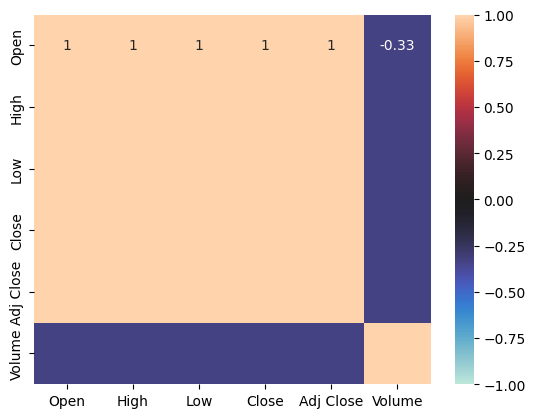

In [12]:
sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap='icefire', annot=True);

In [11]:
data.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999479,0.999332,0.998715,0.998715,-0.332099
High,0.999479,1.000000,0.999172,0.999393,0.999393,-0.329235
Low,0.999332,0.999172,1.000000,0.999358,0.999358,-0.335197
Close,0.998715,0.999393,0.999358,1.000000,1.000000,-0.332461
Adj Close,0.998715,0.999393,0.999358,1.000000,1.000000,-0.332461
Volume,-0.332099,-0.329235,-0.335197,-0.332461,-0.332461,1.000000


    Исходя из тепловой талицы корреляции признаков, видно что цена сильно скоррелированы между собой, по этому дальше я буду использовать только цену закрытия.
    Это позволит избавиться от сильной связи в признаках, а так же существенно сократить число признаков. Так же оставлю объем торгов.

In [12]:
data_crop = data[['Close', 'Volume']]

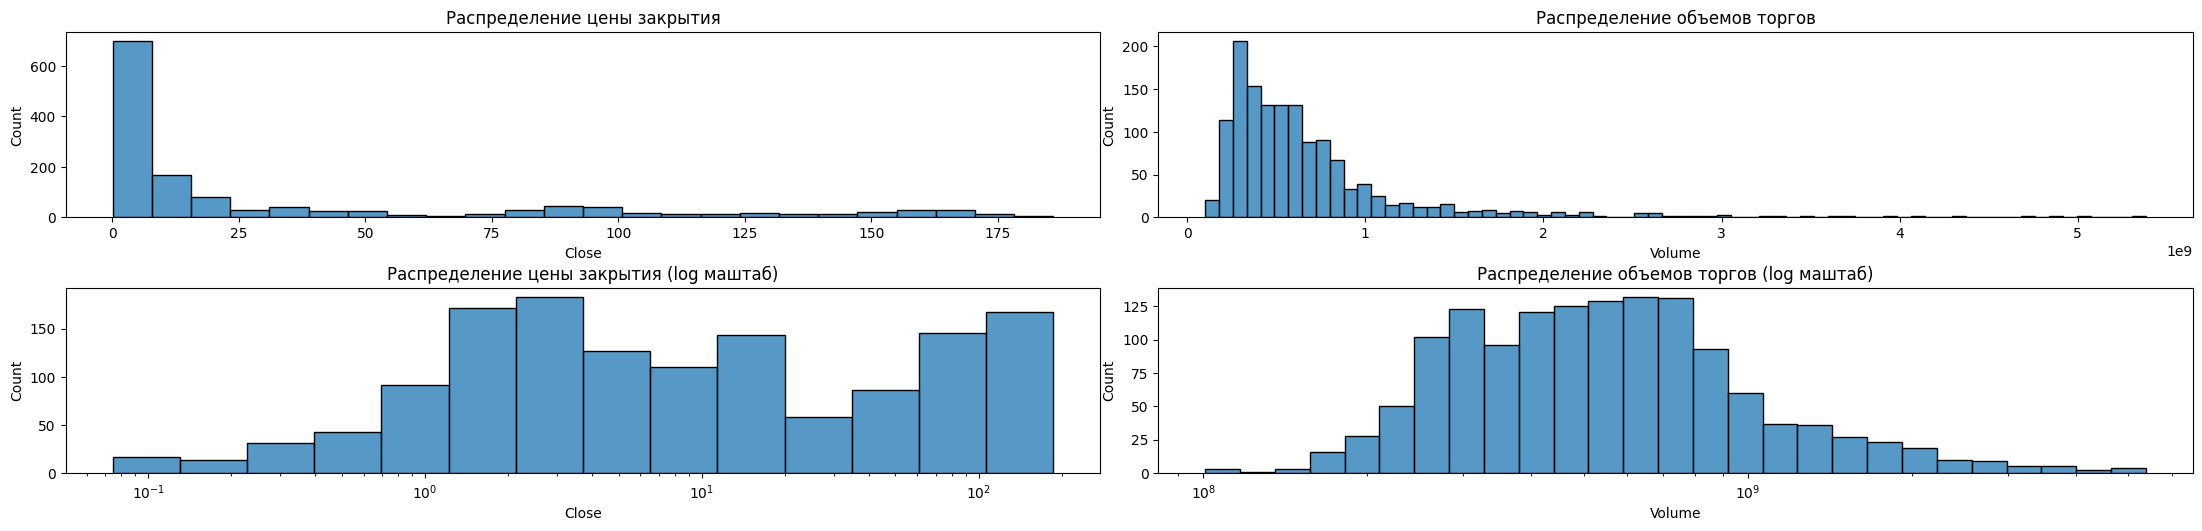

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(22,5))   #, figsize(10,3)
fig.tight_layout(h_pad=3)

sns.histplot(data_crop['Close'], log_scale=False, ax=axs[0,0])
axs[0,0].set_title('Распределение цены закрытия')
sns.histplot(data_crop['Volume'], log_scale=False, ax=axs[0,1])
axs[0,1].set_title('Распределение объемов торгов')
sns.histplot(data_crop['Close'], log_scale=True, ax=axs[1,0])
axs[1,0].set_title('Распределение цены закрытия (log маштаб)')
sns.histplot(data_crop['Volume'], log_scale=True, ax=axs[1,1])
axs[1,1].set_title('Распределение объемов торгов (log маштаб)');
# fig.suptitle('test title')

    Распределение в объемах похоже на логнормальное, а в цене закрытия не сильно похоже на логнормальное.
    Но в логарифмической системе счисления, не неблюдается скопление большого числа данные в районе нуля.
    По этому дальше буду работать с логарифмическими значениями данных.

## Подготовка выборок

In [14]:
import numpy as np

data_crop_log = data_crop.copy()
for column in data_crop.columns:
    data_crop_log[column] = np.log2(data_crop[column])

Теперь необходимо отнормировать данные

In [17]:
from sklearn.preprocessing import StandardScaler

def CreatAndFitScallers(data: pd.DataFrame):
    """Возвращает словарь обученных Scallers, ключ соответствует имени колонки"""
    scallers = dict()
    for column in data:
        scallers[column] = StandardScaler()
        scallers[column].fit(data[[column]])
        # print(data_crop_log[column])
    return scallers

scallers = CreatAndFitScallers(data_crop_log)
# scaler_standart.transform(data_crop_log)

,Close,Volume
count,1.390000e+03,1.390000e+03
mean,-8.178909e-17,8.669644e-15
std,1.000360e+00,1.000360e+00
min,-2.528186e+00,-2.712078e+00
25%,-7.628709e-01,-7.644258e-01
50%,-9.426261e-02,-5.553645e-02
75%,9.050388e-01,5.763930e-01
max,1.643082e+00,3.692249e+00


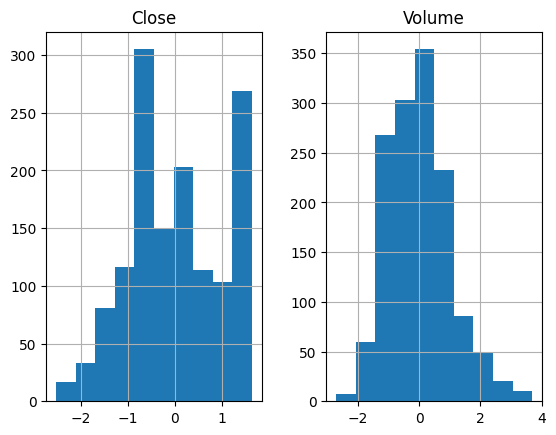

In [18]:
data_crop_log_Scalled = pd.DataFrame(
    data={column: scallers[column].transform(data_crop_log[[column]]).reshape(-1) for column in data_crop_log},
    index=data_crop_log.index)

# data_crop_log_Scalled
data_crop_log_Scalled.hist()
data_crop_log_Scalled.describe()

Далее посмотрим на сезонность в данных

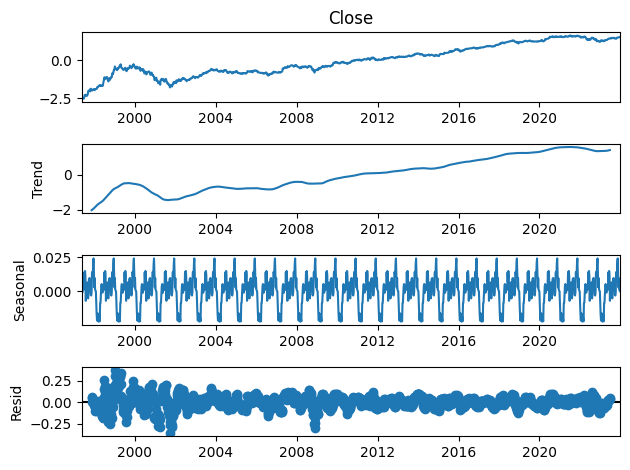

In [19]:
result = seasonal_decompose(data_crop_log_Scalled.Close)
result.plot();

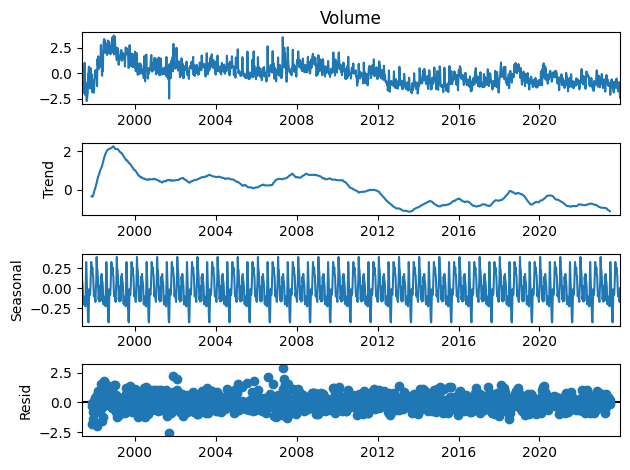

In [20]:
result = seasonal_decompose(data_crop_log_Scalled.Volume)
result.plot();

    В данных присутсвует сезонность. А так же тренд.
    У цены он положительный, а у объемов отрицательный.

Данные с разбивкой по годам

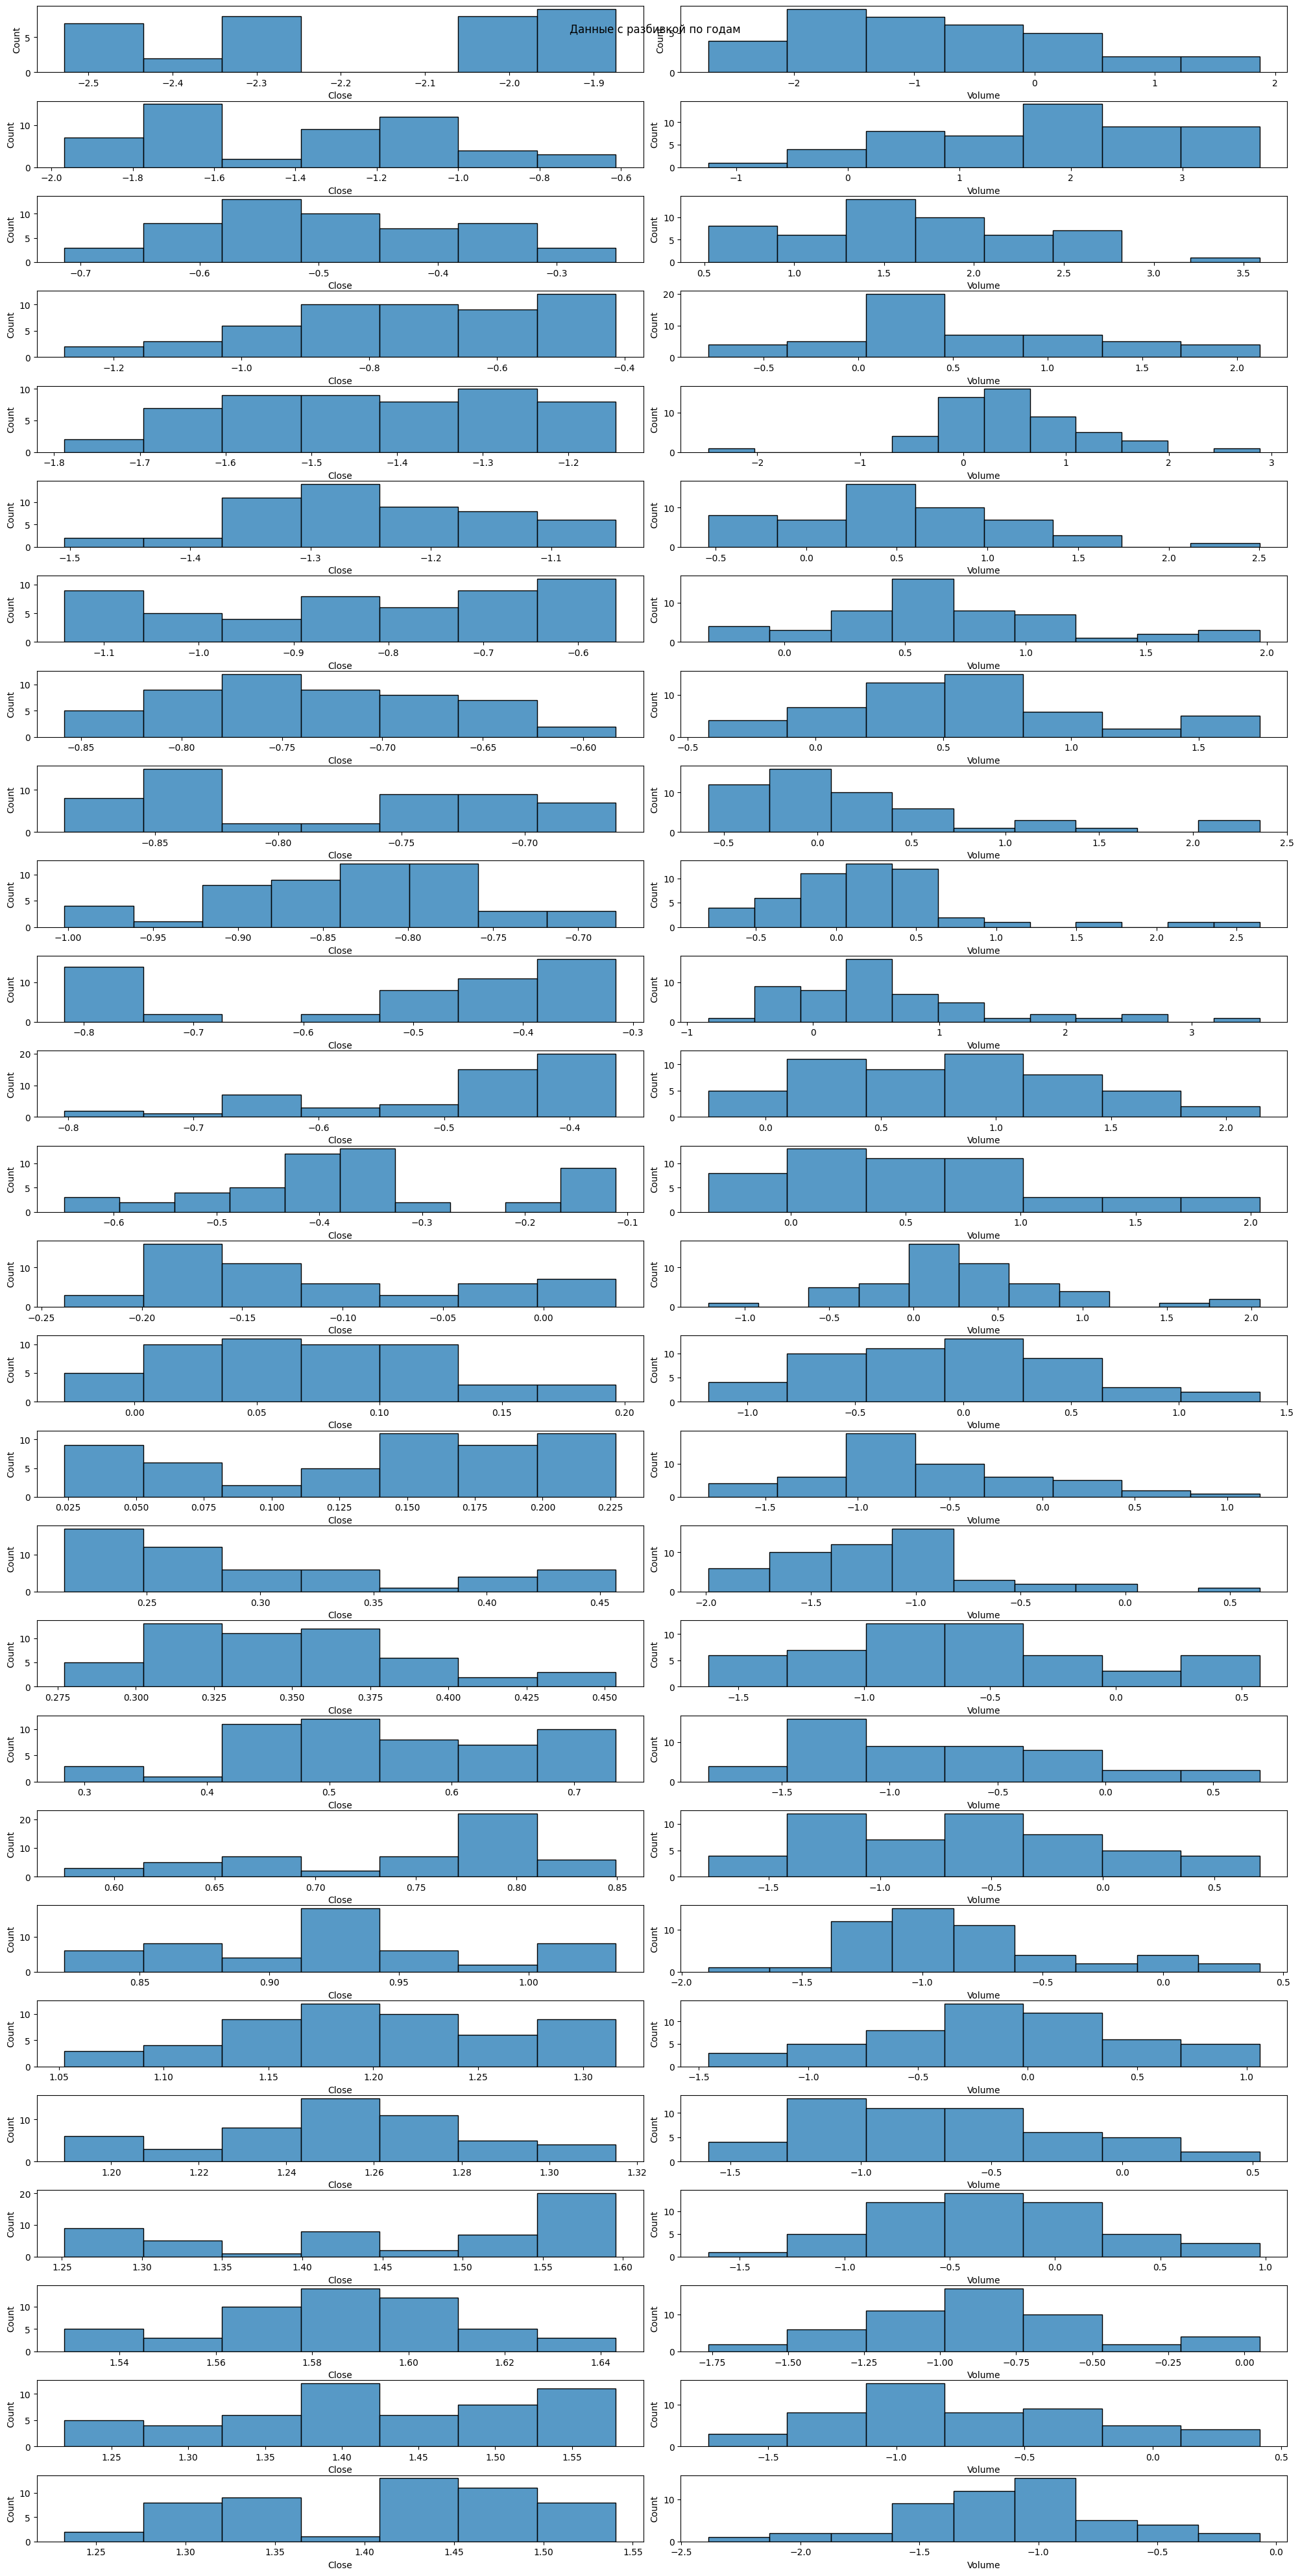

In [21]:
# Формирую интервалы дат для вывода распределений по годам
years = [[f'{year}-01-01',f'{year}-12-31'] for year in range(1997,2024)]
years[0][0] = data_crop_log_Scalled.index[0]
years[-1][1] = data_crop_log_Scalled.index[-1]
# print(years)
fig, axs = plt.subplots(nrows=years.__len__(),
                        ncols=2,
                        figsize=(20,40))
fig.suptitle('Данные с разбивкой по годам')
fig.tight_layout()#h_pad=3

for i, year in enumerate(years):
    sns.histplot(data_crop_log_Scalled[year[0]:year[1]].Close, ax=axs[i,0])
    sns.histplot(data_crop_log_Scalled[year[0]:year[1]].Volume, ax=axs[i,1])

    

    Распределение цен меняется от года к году, в то время как разспределение обдъемов похоже на нормальное

# 2. Применение ML и DL

Перед тем как начать, сформирую класс, в которой буду хранить результаты экспериментов

In [22]:
class Result(dict):
    def __init__(self, model_name: str, IsLogData: bool, model: any, MAPE_Train: float, MAPE_Test: float, pred_test: any):
        """Создает словарь из переданных значений"""
        super().__init__()
        self['model_name'] = model_name
        self['IsLogData'] = IsLogData
        self['model'] = model
        self['MAPE_Train'] = MAPE_Train
        self['MAPE_Test'] = MAPE_Test
        self['pred_test'] = pred_test

# class Results():
#     def __init__(self):
#         self.results = list()
    
#     def append(self, model_name: str, IsLogData: bool, model: any, MAPE_Train: float, MAPE_Test: float, pred_test: any):
#         self.results.append(Result(*CreateModelRegressorAndGetMAPE(*data, False, axs[0], modelName, model)))

results = list()

In [23]:
# Test для results
results.append(Result('Linear', False, 'bbb', 0.2, 0.3, [2]))
print(results)
print(pd.DataFrame(results))
results.clear()

[{'model_name': 'Linear', 'IsLogData': False, 'model': 'bbb', 'MAPE_Train': 0.2, 'MAPE_Test': 0.3, 'pred_test': [2]}]
  model_name  IsLogData model  MAPE_Train  MAPE_Test pred_test
0     Linear      False   bbb         0.2        0.3       [2]


## Задача регрессии

Для начала рассмотрим данную задачу, как задачу регрессии.

Разобъем данные для регрессионных моделей train/test как 70%/30% и сформируем целевой признак используя окно 10.

In [24]:
# crop_index = round(data.shape[0]*0.7)
# train_data_log = data_crop_log_Scalled.iloc[:crop_index].Close
# test_data_log = data_crop_log_Scalled.iloc[crop_index:].Close

# train_data = data_crop.iloc[:crop_index].Close
# test_data = data_crop.iloc[crop_index:].Close


In [25]:
def CreateDataWithWindow(data: pd.DataFrame, train_shape=0.7, window=10):
    """Разбивает DataFrame на Train и Test, а так же отделяет целевой признак для Train и Test"""
    # window = 10
    crop_index = round(data.shape[0]*train_shape)
    train_data = data.iloc[:crop_index].Close
    test_data = data.iloc[crop_index:].Close

    # Формирую tran DataSet
    trainWithWindowAndTarget = pd.DataFrame()
    for i in range(1, window):
        trainWithWindowAndTarget[f'Close{i}']=train_data.shift(i)

    # target_temp = train_data[window:]
    # target_temp.index = train_data[window - 1:-1].index
    target_temp = train_data[window:].copy()
    trainWithWindowAndTarget['Target'] = target_temp

    trainWithWindowAndTarget.dropna(axis=0, inplace=True)
    display(trainWithWindowAndTarget)
    # Формирую Тренировочные данные
    X_train = trainWithWindowAndTarget.drop(labels=['Target'], axis=1)
    y_train = trainWithWindowAndTarget['Target']

    # Формирую test DataSet
    testWithWindowAndTarget = pd.DataFrame()
    for i in range(1, window):
        testWithWindowAndTarget[f'Close{i}']=test_data.shift(i)

    # target_temp = test_data[:-window]
    # target_temp.index = test_data[window:].index
    target_temp = test_data[window:]
    testWithWindowAndTarget['Target'] = target_temp

    testWithWindowAndTarget.dropna(axis=0, inplace=True)
    display(testWithWindowAndTarget)
    # Формирую Тренировочные данные
    X_test = testWithWindowAndTarget.drop(labels=['Target'], axis=1)
    y_test = testWithWindowAndTarget['Target']
    
    return [X_train, X_test, y_train, y_test], train_data, test_data

In [26]:
# train_data, test_data = CreateDataWithWindow(data=data_crop, train_shape=0.7, window=10)
# train_data_log, test_data_log = CreateDataWithWindow(data=data_crop_log_Scalled, train_shape=0.7, window=10)

# X_train, X_test, y_train, y_test = CreateDataWithWindow(data=data_crop, train_shape=0.7, window=10)
# X_train_log, X_test_log, y_train_log, y_test_log = CreateDataWithWindow(data=data_crop_log_Scalled, train_shape=0.7, window=10)

data, train_data, test_data = CreateDataWithWindow(data=data_crop, train_shape=0.7, window=10)
data_log, train_data_log, test_data_log = CreateDataWithWindow(data=data_crop_log_Scalled, train_shape=0.7, window=10)

,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Target
Date,,,,,,,,,,
1997-07-21,0.107813,0.114583,0.095573,0.074479,0.076302,0.079167,0.082813,0.075000,0.075000,0.111458
1997-07-28,0.111458,0.107813,0.114583,0.095573,0.074479,0.076302,0.079167,0.082813,0.075000,0.120833
1997-08-04,0.120833,0.111458,0.107813,0.114583,0.095573,0.074479,0.076302,0.079167,0.082813,0.114583
1997-08-11,0.114583,0.120833,0.111458,0.107813,0.114583,0.095573,0.074479,0.076302,0.079167,0.105729
1997-08-18,0.105729,0.114583,0.120833,0.111458,0.107813,0.114583,0.095573,0.074479,0.076302,0.106250
...,...,...,...,...,...,...,...,...,...,...
2015-11-30,33.662998,33.422501,32.117500,32.968498,31.295000,29.951500,28.538000,26.990000,26.627001,33.632000
2015-12-07,33.632000,33.662998,33.422501,32.117500,32.968498,31.295000,29.951500,28.538000,26.990000,32.007500
2015-12-14,32.007500,33.632000,33.662998,33.422501,32.117500,32.968498,31.295000,29.951500,28.538000,33.207001


,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Target
Date,,,,,,,,,,
2016-03-14,28.480499,28.757000,27.761499,26.745001,25.354000,25.106501,29.350000,29.819000,28.509001,27.604000
2016-03-21,27.604000,28.480499,28.757000,27.761499,26.745001,25.354000,25.106501,29.350000,29.819000,29.147499
2016-03-28,29.147499,27.604000,28.480499,28.757000,27.761499,26.745001,25.354000,25.106501,29.350000,29.924999
2016-04-04,29.924999,29.147499,27.604000,28.480499,28.757000,27.761499,26.745001,25.354000,25.106501,29.730000
2016-04-11,29.730000,29.924999,29.147499,27.604000,28.480499,28.757000,27.761499,26.745001,25.354000,31.294500
...,...,...,...,...,...,...,...,...,...,...
2023-11-27,146.740005,145.179993,143.559998,138.600006,127.739998,125.169998,129.789993,127.959999,127.120003,147.029999
2023-12-04,147.029999,146.740005,145.179993,143.559998,138.600006,127.739998,125.169998,129.789993,127.959999,147.419998
2023-12-11,147.419998,147.029999,146.740005,145.179993,143.559998,138.600006,127.739998,125.169998,129.789993,149.970001


,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Target
Date,,,,,,,,,,
1997-07-21,-2.330958,-2.298484,-2.395215,-2.528186,-2.515291,-2.495637,-2.471628,-2.524469,-2.524469,-2.313229
1997-07-28,-2.313229,-2.330958,-2.298484,-2.395215,-2.528186,-2.515291,-2.495637,-2.471628,-2.524469,-2.270165
1997-08-04,-2.270165,-2.313229,-2.330958,-2.298484,-2.395215,-2.528186,-2.515291,-2.495637,-2.471628,-2.298484
1997-08-11,-2.298484,-2.270165,-2.313229,-2.330958,-2.298484,-2.395215,-2.528186,-2.515291,-2.495637,-2.341366
1997-08-18,-2.341366,-2.298484,-2.270165,-2.313229,-2.330958,-2.298484,-2.395215,-2.528186,-2.515291,-2.338745
...,...,...,...,...,...,...,...,...,...,...
2015-11-30,0.731720,0.727897,0.706660,0.720604,0.692827,0.669430,0.643652,0.613915,0.606695,0.731229
2015-12-07,0.731229,0.731720,0.727897,0.706660,0.720604,0.692827,0.669430,0.643652,0.613915,0.704831
2015-12-14,0.704831,0.731229,0.731720,0.727897,0.706660,0.720604,0.692827,0.669430,0.643652,0.724448


,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Target
Date,,,,,,,,,,
2016-03-14,0.642577,0.647729,0.628943,0.609052,0.580573,0.575342,0.658612,0.667066,0.643110,0.625909
2016-03-21,0.625909,0.642577,0.647729,0.628943,0.609052,0.580573,0.575342,0.658612,0.667066,0.654921
2016-03-28,0.654921,0.625909,0.642577,0.647729,0.628943,0.609052,0.580573,0.575342,0.658612,0.668958
2016-04-04,0.668958,0.654921,0.625909,0.642577,0.647729,0.628943,0.609052,0.580573,0.575342,0.665472
2016-04-11,0.665472,0.668958,0.654921,0.625909,0.642577,0.647729,0.628943,0.609052,0.580573,0.692818
...,...,...,...,...,...,...,...,...,...,...
2023-11-27,1.516759,1.511059,1.505076,1.486328,1.442820,1.431982,1.451309,1.443737,1.440225,1.517811
2023-12-04,1.517811,1.516759,1.511059,1.505076,1.486328,1.442820,1.431982,1.451309,1.443737,1.519224
2023-12-11,1.519224,1.517811,1.516759,1.511059,1.505076,1.486328,1.442820,1.431982,1.451309,1.528368


### Предсказание линейной регрессией (BaseLine)

In [27]:
# Пробую реализовать данный код с использованием pipeline

from sklearn.metrics import mean_absolute_percentage_error as MAPE

def CreateModelRegressorAndGetMAPE(X_train, X_test, y_train, y_test, isLogData: bool, ax: plt.axes, modelName:str, model, draw_all_test=False):
    """Обучает модель. \n
Возвращает --> (modelName:str, isLogData: bool, Model, MAPE на Train данныех, MAPE на Test данных)"""
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    print(f'Данные в LOG масштабе: {isLogData}')
    print(f'* {modelName}, Train data, MAPE=%.3f' % MAPE(y_train, pred_train))
    print(f'* {modelName}, Test data, MAPE=%.3f' % MAPE(y_test, pred_test))

    # Рисую предсказание для последних 100 дней тестовых данных
    pred_test = pd.Series(data=pred_test,
                                index=y_test.index)
    if not draw_all_test:
        y_test[-100:].plot.line(ax=ax)
        pred_test[-100:].plot.line(ax=ax)
    else:
        y_test.plot.line(ax=ax)
        pred_test.plot.line(ax=ax)
    ax.set_title('Log данные' if isLogData else 'Не Log данные')
    ax.legend(['Data', 'Predict'])

    return modelName, isLogData, model, MAPE(y_train, pred_train), MAPE(y_test, pred_test), pred_test

Данные в LOG масштабе: False
* LinearRegression, Train data, MAPE=0.060
* LinearRegression, Test data, MAPE=0.032
Данные в LOG масштабе: True
* LinearRegression, Train data, MAPE=0.205
* LinearRegression, Test data, MAPE=0.014


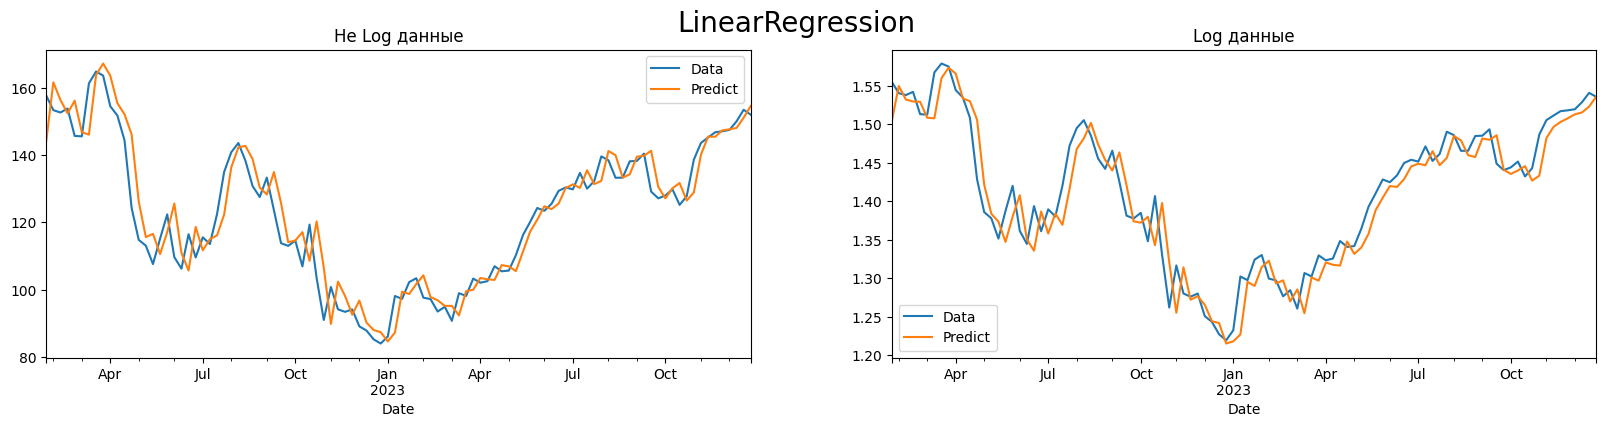

In [29]:
from sklearn.linear_model import LinearRegression

modelName = 'LinearRegression'
model = LinearRegression()

fig, axs = plt.subplots(1, 2, figsize=(20,4))
fig.suptitle(modelName, fontsize=20)

results.append(Result(*CreateModelRegressorAndGetMAPE(*data, False, axs[0], modelName, model)))
results.append(Result(*CreateModelRegressorAndGetMAPE(*data_log, True, axs[1], modelName, model)))

### Reg

Данные в LOG масштабе: False
* Ridge, Train data, MAPE=0.060
* Ridge, Test data, MAPE=0.032
Данные в LOG масштабе: True
* Ridge, Train data, MAPE=0.204
* Ridge, Test data, MAPE=0.015


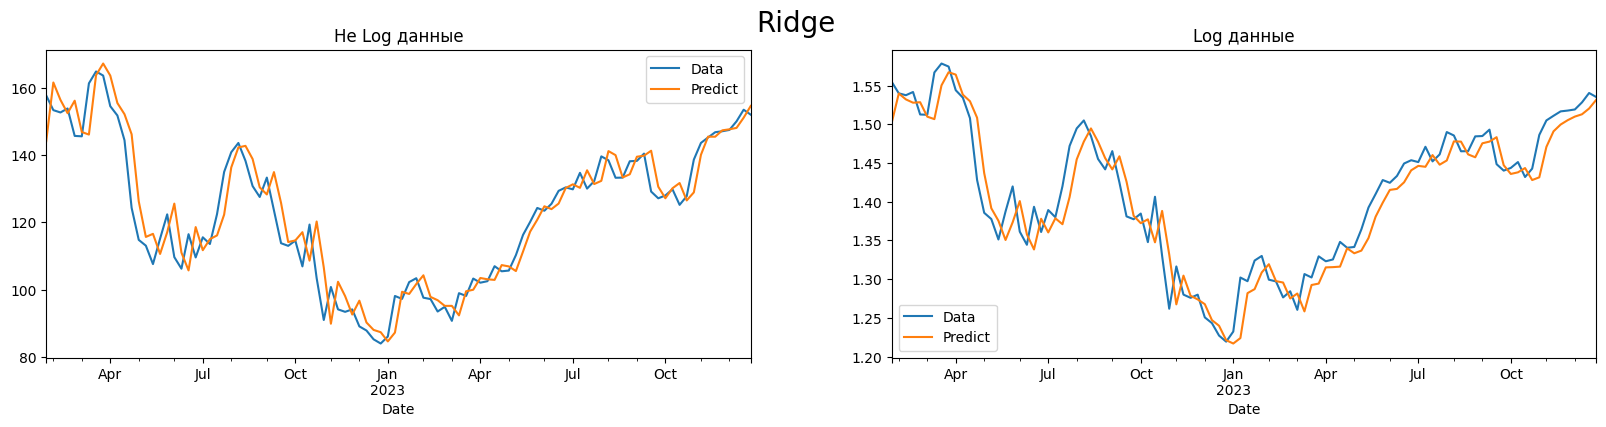

In [32]:
from sklearn.linear_model import Ridge


modelName = 'Ridge'
model = Ridge(alpha=0.5)

fig, axs = plt.subplots(1, 2, figsize=(20,4))
fig.suptitle(modelName, fontsize=20)

results.append(Result(*CreateModelRegressorAndGetMAPE(*data, False, axs[0], modelName, model)))
results.append(Result(*CreateModelRegressorAndGetMAPE(*data_log, True, axs[1], modelName, model)))

### Lasso

Данные в LOG масштабе: False
* Lasso, Train data, MAPE=0.058
* Lasso, Test data, MAPE=0.031
Данные в LOG масштабе: True
* Lasso, Train data, MAPE=1.451
* Lasso, Test data, MAPE=0.358


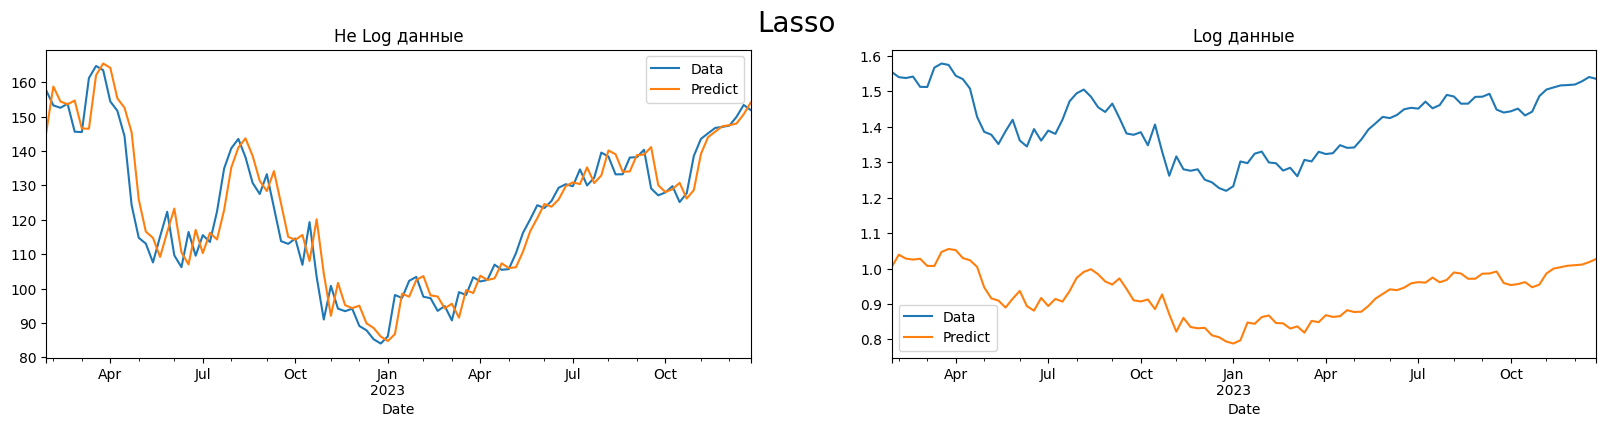

In [33]:
from sklearn.linear_model import Lasso


modelName = 'Lasso'
model = Lasso(alpha=0.1)

fig, axs = plt.subplots(1, 2, figsize=(20,4))
fig.suptitle(modelName, fontsize=20)

results.append(Result(*CreateModelRegressorAndGetMAPE(*data, False, axs[0], modelName, model)))
results.append(Result(*CreateModelRegressorAndGetMAPE(*data_log, True, axs[1], modelName, model)))

### ElasticNet

Данные в LOG масштабе: False
* ElasticNet, Train data, MAPE=0.081
* ElasticNet, Test data, MAPE=0.038
Данные в LOG масштабе: True
* ElasticNet, Train data, MAPE=5.586
* ElasticNet, Test data, MAPE=1.430


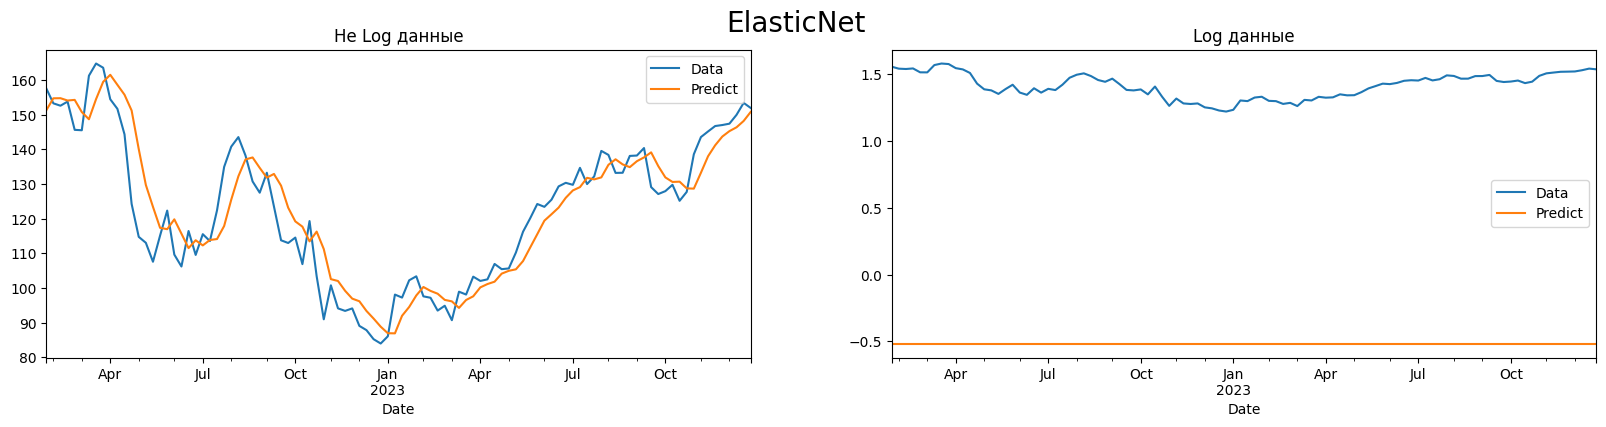

In [34]:
from sklearn.linear_model import ElasticNet


modelName = 'ElasticNet'
model = ElasticNet(random_state=0)

fig, axs = plt.subplots(1, 2, figsize=(20,4))
fig.suptitle(modelName, fontsize=20)

results.append(Result(*CreateModelRegressorAndGetMAPE(*data, False, axs[0], modelName, model)))
results.append(Result(*CreateModelRegressorAndGetMAPE(*data_log, True, axs[1], modelName, model)))

### Полиномиальная модель

In [35]:
from sklearn.preprocessing import PolynomialFeatures

# Создаю Полиномиальные признаки
def CreatPolyFeatures(data, *args, **kwargs):
    """Создает Полиномиальные признаки. \n
    Вход Data: DataFrame, остальное уйдет в PolynomialFeatures(*args, **kwargs) \n
    Возвращает Массив Полиномиальных признаков"""
    poly2 = PolynomialFeatures(*args, **kwargs) #degree=2, include_bias=True
    data_poly = data.copy()
    data_poly[0] = poly2.fit_transform(data_poly[0]) # X_train
    data_poly[1] = poly2.transform(data_poly[1])
    return data_poly

Данные в LOG масштабе: False
* Polynomial_2_Ridge, Train data, MAPE=0.061
* Polynomial_2_Ridge, Test data, MAPE=0.134
Данные в LOG масштабе: True
* Polynomial_2_Ridge, Train data, MAPE=0.228
* Polynomial_2_Ridge, Test data, MAPE=0.020


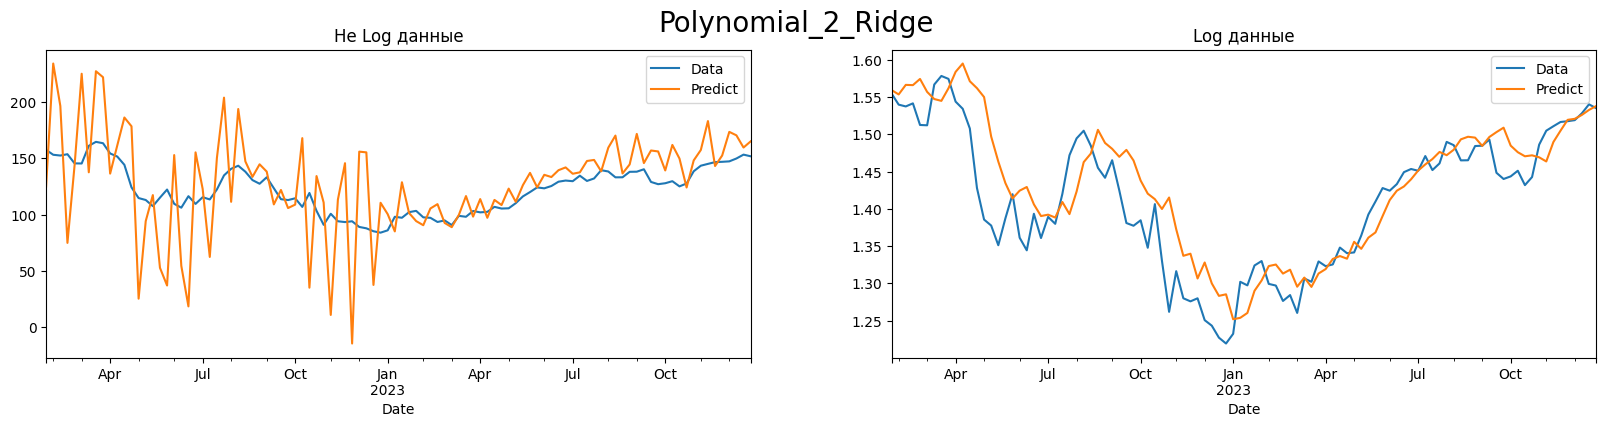

In [36]:
Polynomial_Num = 2
modelName = f'Polynomial_{Polynomial_Num}_Ridge'
model = Ridge()

fig, axs = plt.subplots(1, 2, figsize=(20,4))
fig.suptitle(modelName, fontsize=20)

data_poly = CreatPolyFeatures(data, degree=2, include_bias=True)
results.append(Result(*CreateModelRegressorAndGetMAPE(*data_poly, False, axs[0], modelName, model)))
data_poly_log = CreatPolyFeatures(data_log, degree=Polynomial_Num, include_bias=True)
results.append(Result(*CreateModelRegressorAndGetMAPE(*data_poly_log, True, axs[1], modelName, model)))
# print(pd.DataFrame(results))

Данные в LOG масштабе: False
* Polynomial_3_Ridge, Train data, MAPE=0.061
* Polynomial_3_Ridge, Test data, MAPE=0.134
Данные в LOG масштабе: True
* Polynomial_3_Ridge, Train data, MAPE=0.243
* Polynomial_3_Ridge, Test data, MAPE=0.037


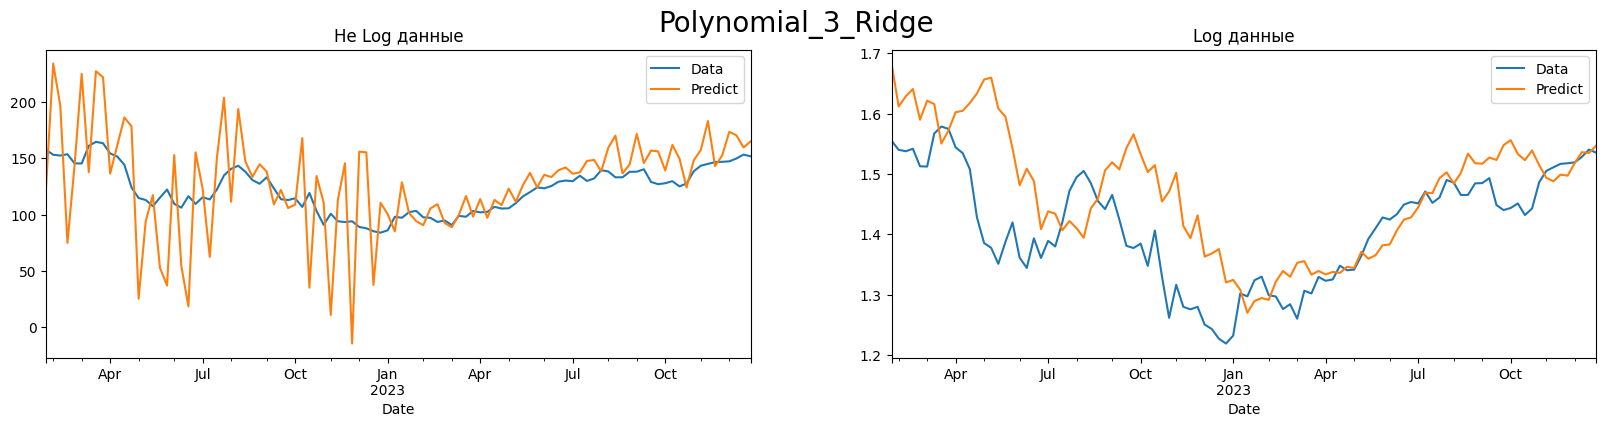

In [37]:
Polynomial_Num = 3
modelName = f'Polynomial_{Polynomial_Num}_Ridge'
model = Ridge()

fig, axs = plt.subplots(1, 2, figsize=(20,4))
fig.suptitle(modelName, fontsize=20)

data_poly = CreatPolyFeatures(data, degree=2, include_bias=True)
results.append(Result(*CreateModelRegressorAndGetMAPE(*data_poly, False, axs[0], modelName, model)))
data_poly_log = CreatPolyFeatures(data_log, degree=Polynomial_Num, include_bias=True)
results.append(Result(*CreateModelRegressorAndGetMAPE(*data_poly_log, True, axs[1], modelName, model)))
# print(pd.DataFrame(results))

Данные в LOG масштабе: False
* Polynomial_4_Ridge, Train data, MAPE=0.061
* Polynomial_4_Ridge, Test data, MAPE=0.134
Данные в LOG масштабе: True
* Polynomial_4_Ridge, Train data, MAPE=0.250
* Polynomial_4_Ridge, Test data, MAPE=0.075


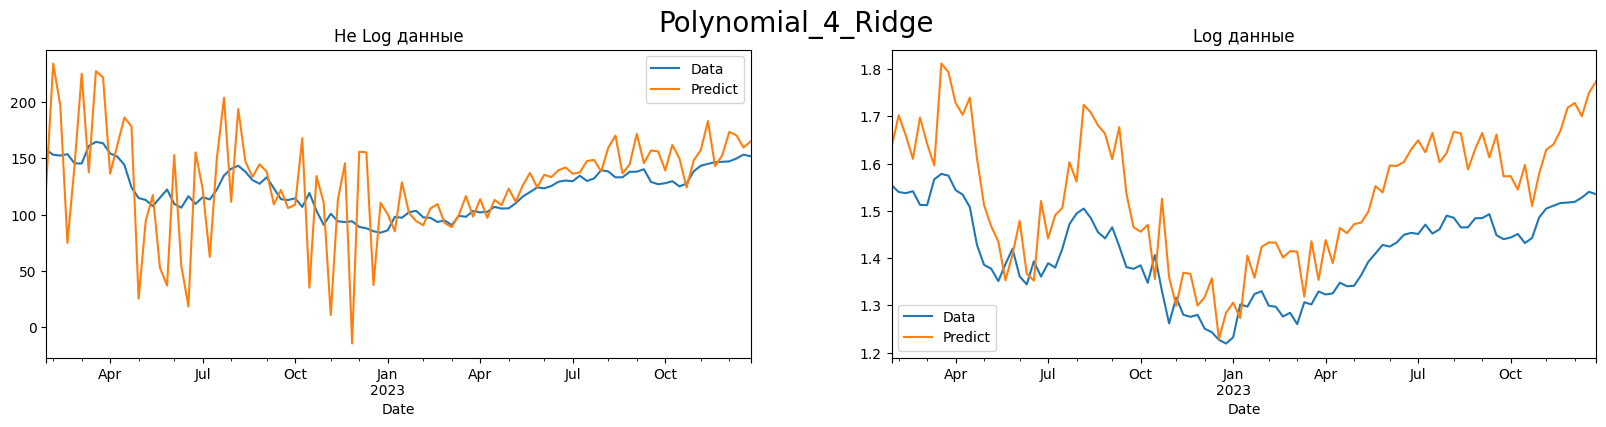

In [38]:
Polynomial_Num = 4
modelName = f'Polynomial_{Polynomial_Num}_Ridge'
model = Ridge()

fig, axs = plt.subplots(1, 2, figsize=(20,4))
fig.suptitle(modelName, fontsize=20)

data_poly = CreatPolyFeatures(data, degree=2, include_bias=True)
results.append(Result(*CreateModelRegressorAndGetMAPE(*data_poly, False, axs[0], modelName, model)))
data_poly_log = CreatPolyFeatures(data_log, degree=Polynomial_Num, include_bias=True)
results.append(Result(*CreateModelRegressorAndGetMAPE(*data_poly_log, True, axs[1], modelName, model)))
# print(pd.DataFrame(results))

### Дерево решений

Данные в LOG масштабе: False
* DecisionTreeRegressor, Train data, MAPE=0.000
* DecisionTreeRegressor, Test data, MAPE=0.603
Данные в LOG масштабе: True
* DecisionTreeRegressor, Train data, MAPE=0.000
* DecisionTreeRegressor, Test data, MAPE=0.414


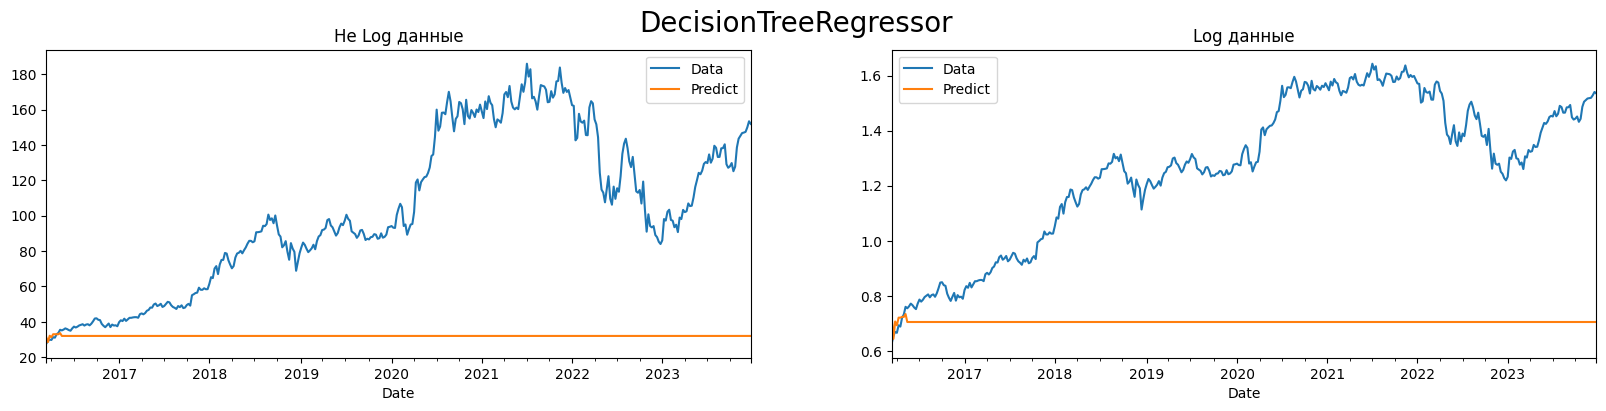

In [39]:
from sklearn.tree import DecisionTreeRegressor


modelName = 'DecisionTreeRegressor'
model = DecisionTreeRegressor(random_state=0)

fig, axs = plt.subplots(1, 2, figsize=(20,4))
fig.suptitle(modelName, fontsize=20)

results.append(Result(*CreateModelRegressorAndGetMAPE(*data, False, axs[0], modelName, model, draw_all_test=True)))
results.append(Result(*CreateModelRegressorAndGetMAPE(*data_log, True, axs[1], modelName, model, draw_all_test=True)))

    Дерево решений не способно предсказать значения, выходящие за рамки обучающей выборки. По этому нам данная модель не подходит.

### Решающий лес

Данные в LOG масштабе: False
* RandomForestRegressor, Train data, MAPE=0.024
* RandomForestRegressor, Test data, MAPE=0.594
Данные в LOG масштабе: True
* RandomForestRegressor, Train data, MAPE=0.051
* RandomForestRegressor, Test data, MAPE=0.404


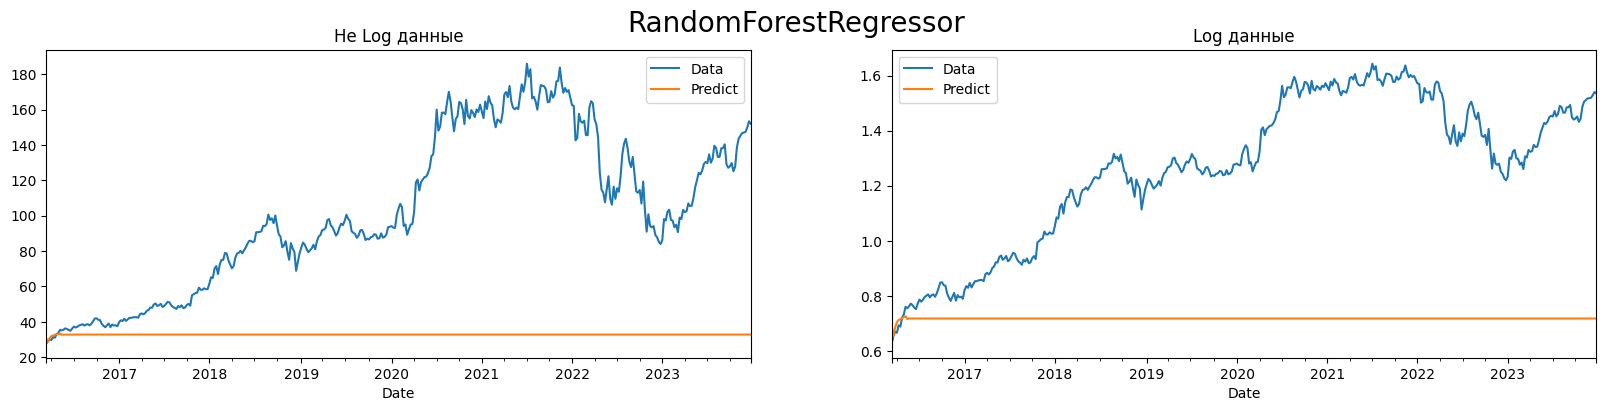

In [40]:
from sklearn.ensemble import RandomForestRegressor


modelName = 'RandomForestRegressor'
model = RandomForestRegressor(random_state=0)

fig, axs = plt.subplots(1, 2, figsize=(20,4))
fig.suptitle(modelName, fontsize=20)

results.append(Result(*CreateModelRegressorAndGetMAPE(*data, False, axs[0], modelName, model, draw_all_test=True)))
results.append(Result(*CreateModelRegressorAndGetMAPE(*data_log, True, axs[1], modelName, model, draw_all_test=True)))

    т.к. модель случайного леса базируется на решающих деревьях, такая модель так же не способна предсказать значение за пределами обучающей выборки.
    Модель решающих деревьев нам так же не подходит.

### Вывод по регрессионным моделям

Визуально сравним результаты предсказания регрессионных модеоей

In [41]:
def DrawPredict(test_data, results , IsLogData, ax , algs=None, last_candles=None):
    """Отображает на графике заданные предсказания"""
    if not last_candles is None:
        test_data.iloc[-last_candles:].plot(ax=ax)
    else:
        test_data.plot(ax=ax)
    dfFromDraw = pd.DataFrame(results)
    mask = dfFromDraw.IsLogData==IsLogData
    dfFromDraw = dfFromDraw[mask]
    if not algs is None:
        # Фильтр по Моделям
        dfFromDraw = dfFromDraw[mask].iloc[algs]
    for row in dfFromDraw.iterrows():
        if not last_candles is None:
            # Фильтр по row с конца
            row[1]['pred_test'].iloc[-last_candles:].plot(ax=ax)
        else:
            row[1]['pred_test'].plot(ax=ax)
    legend = ['test_data'] + list(dfFromDraw['model_name'])
    ax.legend(legend)
    ax.set_title('Log данные' if IsLogData else 'Не Log данные')

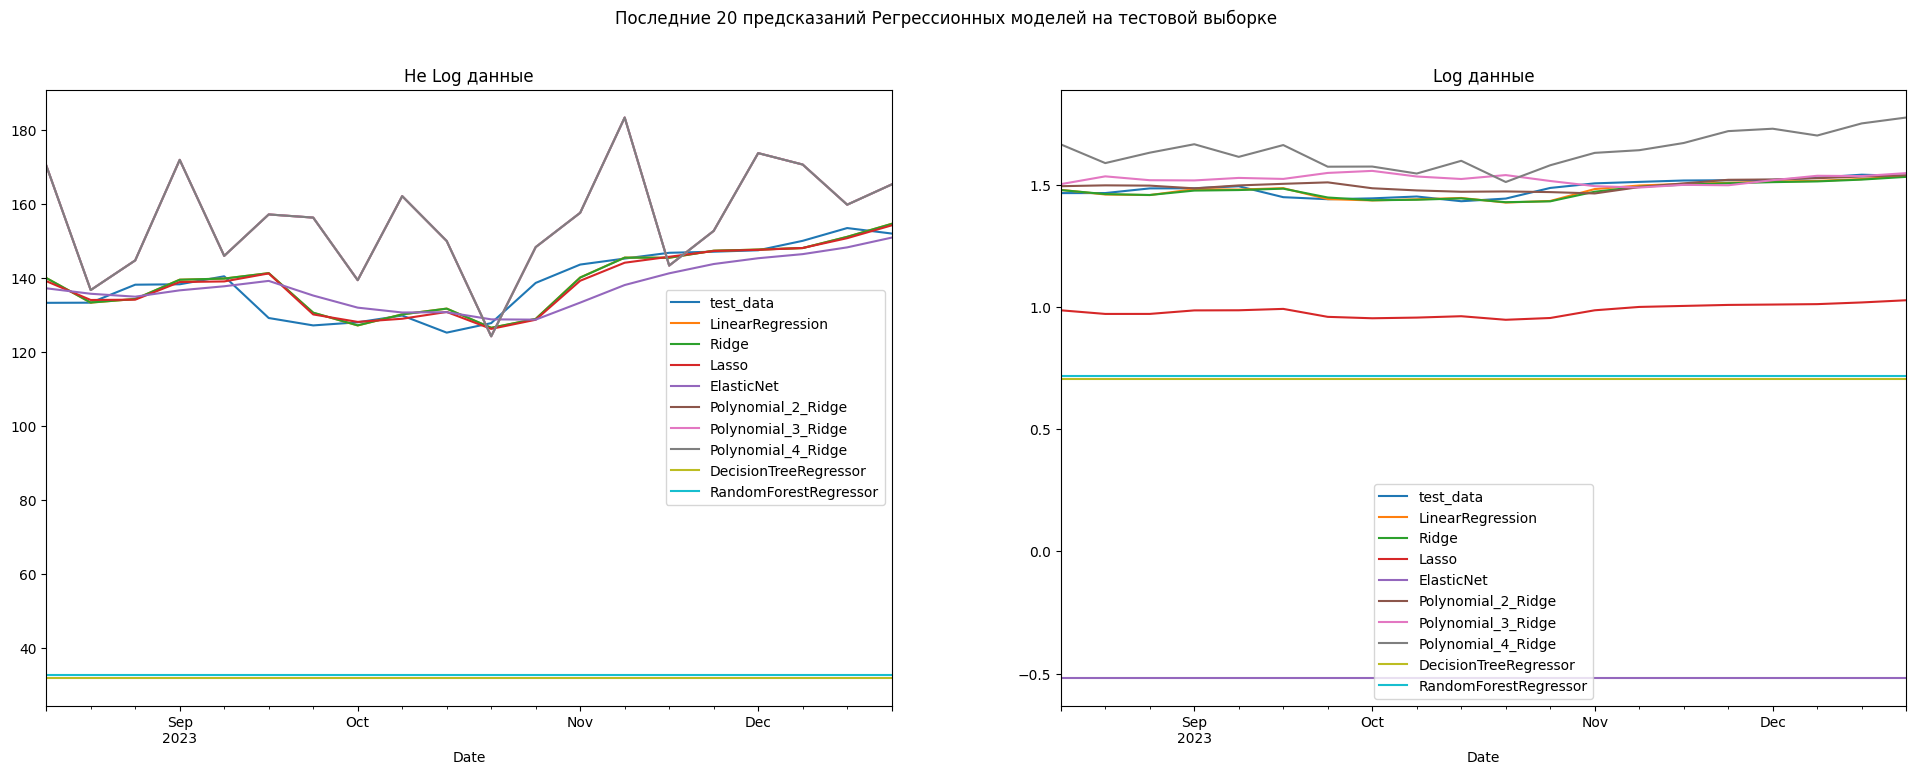

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(24,8))

# dfFromDraw.loc[0]['pred_test'].plot(ax=ax)
    
fig.suptitle('Последние 20 предсказаний Регрессионных моделей на тестовой выборке')
DrawPredict(test_data=test_data, results=results, IsLogData=False, ax=axs[0], last_candles=20)
DrawPredict(test_data=test_data_log, results=results, IsLogData=True, ax=axs[1], last_candles=20)

In [43]:
# ТОП10 регрессионных моделей
pd.DataFrame(results).sort_values(by=['MAPE_Test'], ascending=True)[:10]

,model_name,IsLogData,model,MAPE_Train,MAPE_Test,pred_test
1,LinearRegression,True,LinearRegression(),0.205038,0.014179,Date 2016-03-14 0.632811 2016-03-21 0.62...
3,Ridge,True,Ridge(alpha=0.5),0.203592,0.014812,Date 2016-03-14 0.634219 2016-03-21 0.62...
9,Polynomial_2_Ridge,True,Ridge(),0.228091,0.020387,Date 2016-03-14 0.648537 2016-03-21 0.63...
4,Lasso,False,Lasso(alpha=0.1),0.057509,0.030648,Date 2016-03-14 28.629511 2016-03-21 2...
2,Ridge,False,Ridge(alpha=0.5),0.059593,0.031659,Date 2016-03-14 28.785202 2016-03-21 2...
0,LinearRegression,False,LinearRegression(),0.059592,0.031666,Date 2016-03-14 28.785301 2016-03-21 2...
11,Polynomial_3_Ridge,True,Ridge(),0.243301,0.037132,Date 2016-03-14 0.647224 2016-03-21 0.65...
6,ElasticNet,False,ElasticNet(random_state=0),0.081326,0.038225,Date 2016-03-14 28.334606 2016-03-21 2...
13,Polynomial_4_Ridge,True,Ridge(),0.250412,0.074510,Date 2016-03-14 0.653041 2016-03-21 0.64...
12,Polynomial_4_Ridge,False,Ridge(),0.061123,0.134088,Date 2016-03-14 29.607412 2016-03-21 2...


    Регрессионные модили довольно хорошо себя показывают.
    Линейная регрессия даёт всего 0,014% процента ошибки на логорифмированных и нормированных данных.

## Временные ряды

### Скользящее среднее

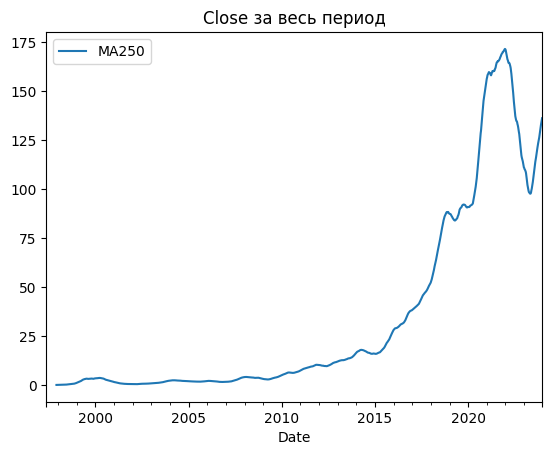

In [44]:
MA = data_crop['Close'].rolling(window=30).mean()
MA.plot()
plt.title('Close за весь период')
plt.legend([f'MA{250}']);


    На графике, с окном 300, видно сильный восходящий тренд. Так же пристуствует коррекция.

### Экспоненциальное сглаживание
это метод прогнозирования временных рядов для одномерных данных с трендом или сезонным компонентом. Оно также известно как метод простого экспоненциального сглаживания, или метод Брауна.

In [45]:
from statsmodels.tsa.api import SimpleExpSmoothing

def GetMAPESimpleExpSmoothing(train_data, test_data, isLogData, ax, modelName):
    ses = SimpleExpSmoothing(train_data)
    alpha = 0.7
    model = ses.fit(
        smoothing_level=alpha,
        optimized=False
    )
    exp_pred = model.forecast(2)
    
    pred_df = pd.DataFrame({'Close': exp_pred})
    train_data[-10:].plot(ax=ax)
    test_data[:5].plot(ax=ax)
    exp_pred.index = test_data[:2].index
    exp_pred.plot(ax=ax)
    ax.legend(['Часть тренировочных данных', 'Часть тестовых данных', 'Предсказание']) 

    print(f'Данные в LOG масштабе: {isLogData}')
    # print(f'* {modelName}, Train data, MAPE=%.3f' % MAPE(y_train, pred_train))
    print(f'* {modelName}, Test data, MAPE=%.3f' % MAPE(test_data[:1], exp_pred[:1]))
    # return exp_pred
    return [modelName, isLogData, model, 999, MAPE(test_data[:1], exp_pred[:1]), exp_pred]

d:\Diplom\research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
d:\Diplom\research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Данные в LOG масштабе: False
* SimpleExpSmoothing, Test data, MAPE=0.106
Данные в LOG масштабе: True
* SimpleExpSmoothing, Test data, MAPE=0.080


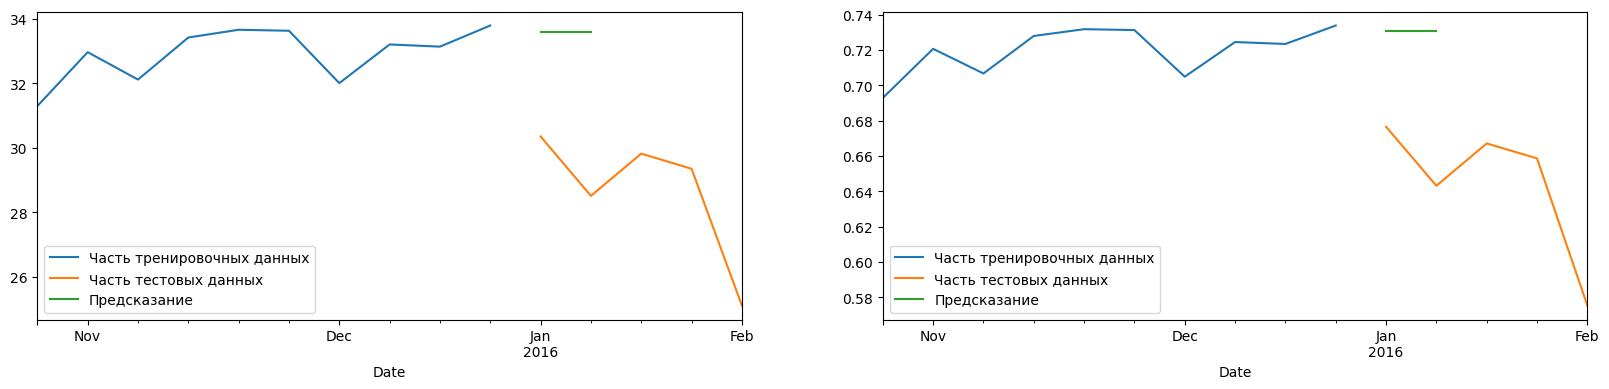

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(20,4))

results.append(Result(*GetMAPESimpleExpSmoothing(train_data, test_data, False, axs[0], 'SimpleExpSmoothing')))
results.append(Result(*GetMAPESimpleExpSmoothing(train_data_log, test_data_log, True, axs[1], 'SimpleExpSmoothing')))

    Модель плохо справилась с предсказанием.

### Авторегрессионные модели

    Тренд, сезонность и цикличность, проверка остатков на шум

С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.

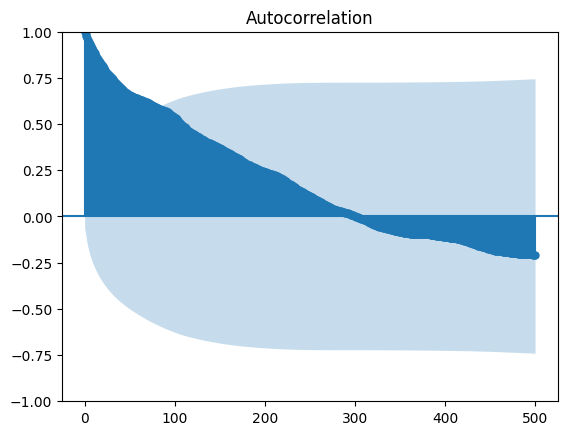

In [47]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train_data, lags=500);

График автокорреляции показывает, что значения сильно скоррелированы со своими предыдущими значениями и сила корреляции постепенно падает.
Так же видно, что в районе 400 лага значение лагов пересекают доверительный интервал.

    Так как максимальное значение на коррелограмме находится в k=1, то ряд содержит только тенденцию (тренд), а циклическая компонента (период) отсутствует.

d:\Diplom\research\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


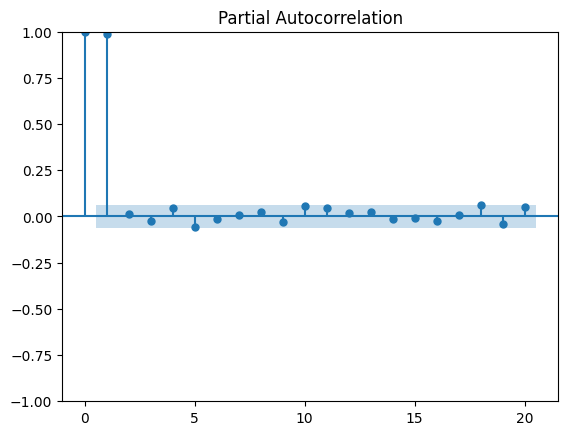

In [48]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(train_data, lags=20);

Проверяю ряд на стационарность

In [49]:
import statsmodels.api as sm

def stat_test(df, isLogData):
    test = sm.tsa.adfuller(df)
    print(f'Данные в LOG масштабе: {isLogData}')
    print ('* adf: ', test[0] )
    print ('* p-value: ', test[1])
    print('* Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('* есть единичные корни, ряд не стационарен')
    else:
        print ('* единичных корней нет, ряд стационарен')

stat_test(train_data, False)
stat_test(train_data_log, False)

Данные в LOG масштабе: False
* adf:  3.6507675536958315
* p-value:  1.0
* Critical values:  {'1%': -3.4372521657769353, '5%': -2.864587159166059, '10%': -2.5683924808864265}
* есть единичные корни, ряд не стационарен
Данные в LOG масштабе: False
* adf:  -1.568057677800949
* p-value:  0.49961642559304853
* Critical values:  {'1%': -3.437215930951362, '5%': -2.864571180534198, '10%': -2.5683839700117868}
* есть единичные корни, ряд не стационарен


По результатам теста Дики-Фуллера видно, что ряд не стационарный. 

Дифференцирую его

In [50]:
df1_train_data = train_data.diff().dropna()
df1_train_data_log = train_data_log.diff().dropna()
stat_test(df1_train_data, False)
stat_test(df1_train_data_log, True)

Данные в LOG масштабе: False
* adf:  -4.43877655739317
* p-value:  0.000253282486917642
* Critical values:  {'1%': -3.43725945868569, '5%': -2.8645903751292536, '10%': -2.5683941938438886}
* единичных корней нет, ряд стационарен
Данные в LOG масштабе: True
* adf:  -7.629134235600596
* p-value:  2.0308218116579667e-11
* Critical values:  {'1%': -3.437215930951362, '5%': -2.864571180534198, '10%': -2.5683839700117868}
* единичных корней нет, ряд стационарен


Ряд стационарен с порядком интегрирования 1 (d=1)

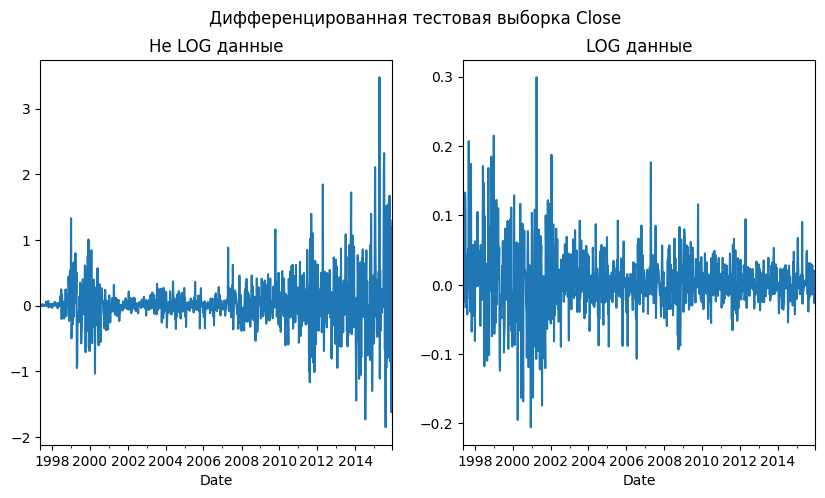

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
df1_train_data.plot(ax=axs[0])
df1_train_data_log.plot(ax=axs[1])

fig.suptitle('Дифференцированная тестовая выборка Close');
axs[0].set_title('Не LOG данные')
axs[1].set_title('LOG данные');

In [52]:
# df1_train_data.info()
# df1_train_data = pd.DataFrame(df1_train_data)
# df1_train_data

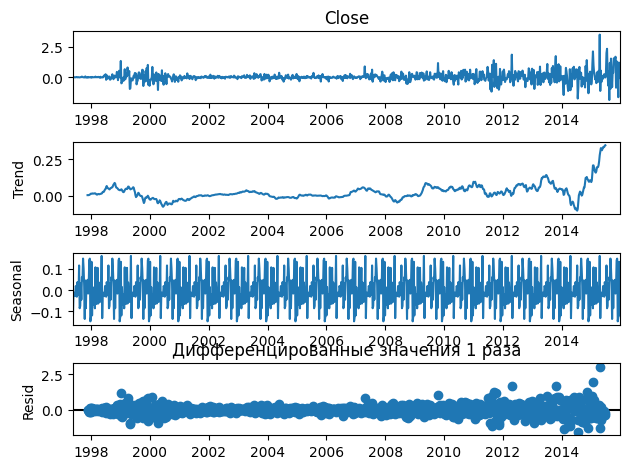

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df1_train_data) #, period=5
result.plot()
plt.title('Дифференцированные значения 1 раза');
plt.show()

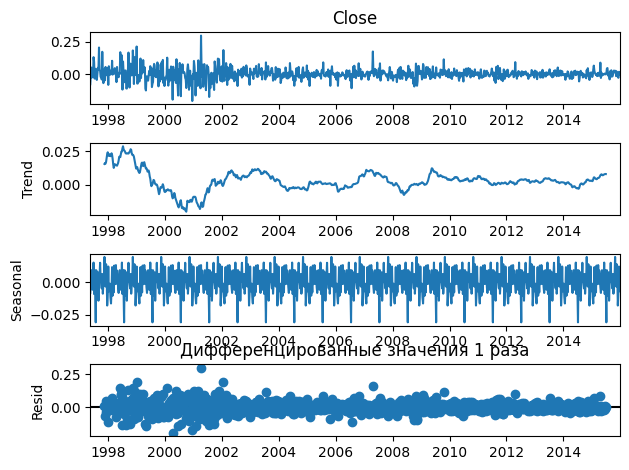

In [54]:
result = seasonal_decompose(df1_train_data_log) #, period=5
result.plot()
plt.title('Дифференцированные значения 1 раза');
plt.show()

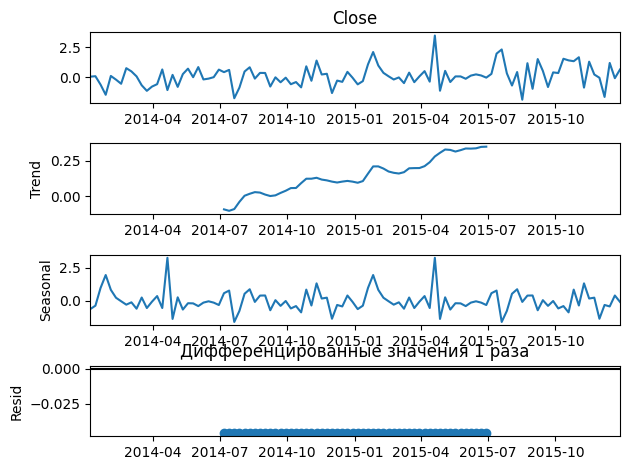

In [55]:
result = seasonal_decompose(df1_train_data[-104:]) #,period=5
result.plot()
plt.title('Дифференцированные значения 1 раза');
plt.show()

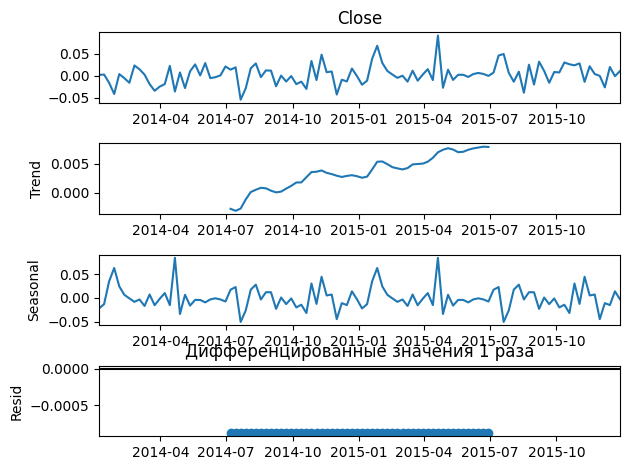

In [56]:
result = seasonal_decompose(df1_train_data_log[-104:]) #,period=5
result.plot()
plt.title('Дифференцированные значения 1 раза');
plt.show()

    Присутсвует тренд и сезонность 52, это примерно год (судя по ошибке, 104 недели это 2 полных цикла)

Определяю порядок AR по графику частичной автокорреляции

d:\Diplom\research\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


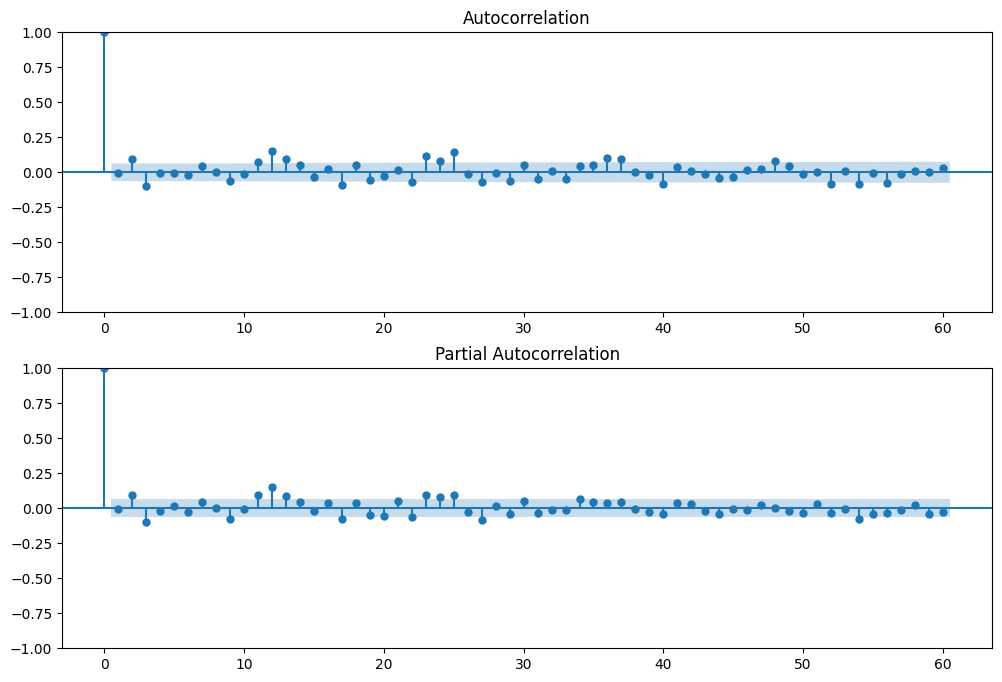

In [57]:
from matplotlib import pyplot as plt
%matplotlib inline 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df1_train_data.values.squeeze(), lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1_train_data, ax=ax2, lags=60)

По графику выше выбираем p=1, q=1, для НЕ LOG данных

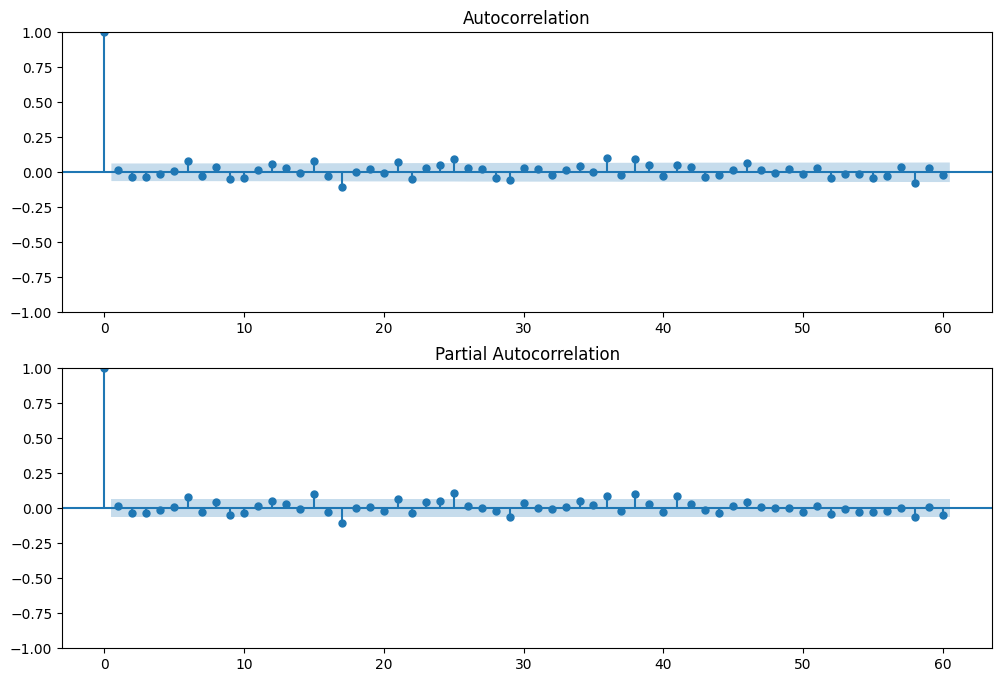

In [58]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df1_train_data_log.values.squeeze(), lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1_train_data_log, ax=ax2, lags=60)

Для LOG данных, выбор аналогичен p=1, q=1

#### AR модель

In [59]:
from statsmodels.tsa.ar_model import AutoReg

def GetMAPEAR(train_data, test_data, isLogData, model_name):
    model_ar = AutoReg(train_data, lags=1)
    model_ar_fit = model_ar.fit()
    print(model_ar_fit.summary())

    pred_ar = model_ar_fit.predict(start=len(train_data), end=len(test_data)+len(train_data)-1, dynamic=False)
    # pred_ar
    print(f'Данные в LOG масштабе: {isLogData}')
    print(f'* {modelName}, Test data, MAPE=%.3f' % MAPE(test_data, pred_ar))
    
    return [model_name, isLogData, model_ar_fit, 999, MAPE(test_data, pred_ar), pred_ar]

results.append(Result(*GetMAPEAR(train_data, test_data, False, 'AutoReg')))
results.append(Result(*GetMAPEAR(train_data_log, test_data_log, True, 'AutoReg')))

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  973
Model:                     AutoReg(1)   Log Likelihood                -480.673
Method:               Conditional MLE   S.D. of innovations              0.397
Date:                Tue, 06 Feb 2024   AIC                            967.345
Time:                        23:00:48   BIC                            981.983
Sample:                    05-19-1997   HQIC                           972.916
                         - 12-28-2015                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0069      0.017     -0.401      0.688      -0.040       0.027
Close.L1       1.0070      0.002    518.795      0.000       1.003       1.011
                                    Roots           

d:\Diplom\research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
d:\Diplom\research\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
d:\Diplom\research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
d:\Diplom\research\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the

Строю модель ARIMA по найденным p, q

In [60]:
from statsmodels.tsa.arima.model import ARIMA

def GetMAPEARIMA(train_data, test_data, isLogData, model_name, order, *args, **kwargs):
    # p, d, q = 1, 1, 1 # order
    model_arima = ARIMA(train_data, order=order, *args, **kwargs)
    model_arima_fit = model_arima.fit()
    print(model_arima_fit.summary())

    pred_arima = model_arima_fit.predict(start=test_data.index[0], end=test_data.index[-1])
    # pred_arima
    print(f'Данные в LOG масштабе: {isLogData}')
    print(f'* {model_name}, Test data, MAPE=%.3f' % MAPE(test_data, pred_arima))

    return [model_name, isLogData, model_arima_fit, 999, MAPE(test_data, pred_arima), pred_arima]


results.append(Result(*GetMAPEARIMA(train_data, test_data, False, 'ARIMA', order=(1,1,1))))
results.append(Result(*GetMAPEARIMA(train_data_log, test_data_log, True, 'ARIMA', order=(1,1,1))))

d:\Diplom\research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
d:\Diplom\research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
d:\Diplom\research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  973
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -488.218
Date:                Tue, 06 Feb 2024   AIC                            982.436
Time:                        23:00:49   BIC                            997.074
Sample:                    05-12-1997   HQIC                           988.007
                         - 12-28-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8541      0.078    -10.991      0.000      -1.006      -0.702
ma.L1          0.8148      0.086      9.481      0.000       0.646       0.983
sigma2         0.1599      0.003     56.221      0.0

d:\Diplom\research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
d:\Diplom\research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
d:\Diplom\research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Данные в LOG масштабе: True
* ARIMA, Test data, MAPE=0.386


Подбираю параметры с помощью пакета pmdarima

In [61]:
import pmdarima as pm
# Подбираю параметры для SARIMA на НЕ LOG данных
smodel = pm.auto_arima(
    train_data,
    start_p=1,
    d=1,
    start_q=0,
    max_p=10,
    max_q=10,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()
results.append(Result(*GetMAPEARIMA(train_data, test_data, False, 'SARIMA', order=smodel.order, seasonal_order=smodel.seasonal_order)))


Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=1637.425, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=1375.906, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.40 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=1639.258, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=1271.797, Time=0.34 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=0.86 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=1270.698, Time=0.23 sec
 ARIMA(0,1,0)(1,1,0)[5]             : AIC=1373.954, Time=0.15 sec
 ARIMA(0,1,0)(2,1,1)[5]             : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(1,1,1)[5]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,1)(2,1,0)[5]             : AIC=1271.894, Time=0.29 sec
 ARIMA(1,1,1)(2,1,0)[5]             : AIC=1262.215, Time=1.06 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=1371.674, Time=0.52 s

d:\Diplom\research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
d:\Diplom\research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
d:\Diplom\research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                            Close   No. Observations:                  973
Model:             ARIMA(2, 1, 3)x(2, 1, [], 5)   Log Likelihood                -596.187
Date:                          Tue, 06 Feb 2024   AIC                           1208.373
Time:                                  23:02:07   BIC                           1247.367
Sample:                              05-12-1997   HQIC                          1223.217
                                   - 12-28-2015                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1866      0.074      2.538      0.011       0.043       0.331
ar.L2          0.5675      0.069      8.274      0.

In [62]:
# Подбираю параметры для SARIMA на LOG данных
smodel = pm.auto_arima(
    train_data_log,
    start_p=1,
    d=1,
    start_q=0,
    max_p=10,
    max_q=10,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()
results.append(Result(*GetMAPEARIMA(train_data_log, test_data_log, True, 'SARIMA', order=smodel.order, seasonal_order=smodel.seasonal_order)))


Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=-2567.863, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=-2812.026, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=1.16 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=-2566.091, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=-2977.781, Time=0.53 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=2.15 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=1.20 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=-2979.192, Time=0.44 sec
 ARIMA(0,1,0)(1,1,0)[5]             : AIC=-2813.761, Time=0.23 sec
 ARIMA(0,1,0)(2,1,1)[5]             : AIC=inf, Time=1.49 sec
 ARIMA(0,1,0)(1,1,1)[5]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,1)(2,1,0)[5]             : AIC=-2977.794, Time=0.47 sec
 ARIMA(1,1,1)(2,1,0)[5]             : AIC=-2975.799, Time=0.66 sec
 ARIMA(0,1,0)(2,1,0)[5] intercept   : AIC=-2977.193, Ti

d:\Diplom\research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
d:\Diplom\research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
d:\Diplom\research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                    
Dep. Variable:                           Close   No. Observations:                  973
Model:             ARIMA(0, 1, 0)x(2, 1, 0, 5)   Log Likelihood                1492.596
Date:                         Tue, 06 Feb 2024   AIC                          -2979.192
Time:                                 23:02:18   BIC                          -2964.570
Sample:                             05-12-1997   HQIC                         -2973.626
                                  - 12-28-2015                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.6659      0.020    -33.592      0.000      -0.705      -0.627
ar.S.L10      -0.4004      0.018    -22.203      0.000     

In [63]:
pfFromDraw = pd.DataFrame(results)
pfFromDraw[pfFromDraw.IsLogData == False].iloc[:,:]

,model_name,IsLogData,model,MAPE_Train,MAPE_Test,pred_test
0,LinearRegression,False,LinearRegression(),0.059592,0.031666,Date 2016-03-14 28.785301 2016-03-21 2...
2,Ridge,False,Ridge(alpha=0.5),0.059593,0.031659,Date 2016-03-14 28.785202 2016-03-21 2...
4,Lasso,False,Lasso(alpha=0.1),0.057509,0.030648,Date 2016-03-14 28.629511 2016-03-21 2...
6,ElasticNet,False,ElasticNet(random_state=0),0.081326,0.038225,Date 2016-03-14 28.334606 2016-03-21 2...
8,Polynomial_2_Ridge,False,Ridge(),0.061123,0.134088,Date 2016-03-14 29.607412 2016-03-21 2...
10,Polynomial_3_Ridge,False,Ridge(),0.061123,0.134088,Date 2016-03-14 29.607412 2016-03-21 2...
12,Polynomial_4_Ridge,False,Ridge(),0.061123,0.134088,Date 2016-03-14 29.607412 2016-03-21 2...
14,DecisionTreeRegressor,False,DecisionTreeRegressor(random_state=0),0.000000,0.603183,Date 2016-03-14 31.295000 2016-03-21 28....
16,RandomForestRegressor,False,"(DecisionTreeRegressor(max_features=1.0, rando...",0.024315,0.593916,Date 2016-03-14 30.587040 2016-03-21 28....
18,SimpleExpSmoothing,False,<statsmodels.tsa.holtwinters.results.HoltWinte...,999.000000,0.106481,Date 2016-01-04 33.584472 2016-01-11 33....


Сравним визуально результаты предсказаний авторегрессионных моделей

C:\Users\mazun\AppData\Local\Temp\ipykernel_17972\2950933582.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfFromDraw = dfFromDraw[mask].iloc[algs]
C:\Users\mazun\AppData\Local\Temp\ipykernel_17972\2950933582.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfFromDraw = dfFromDraw[mask].iloc[algs]


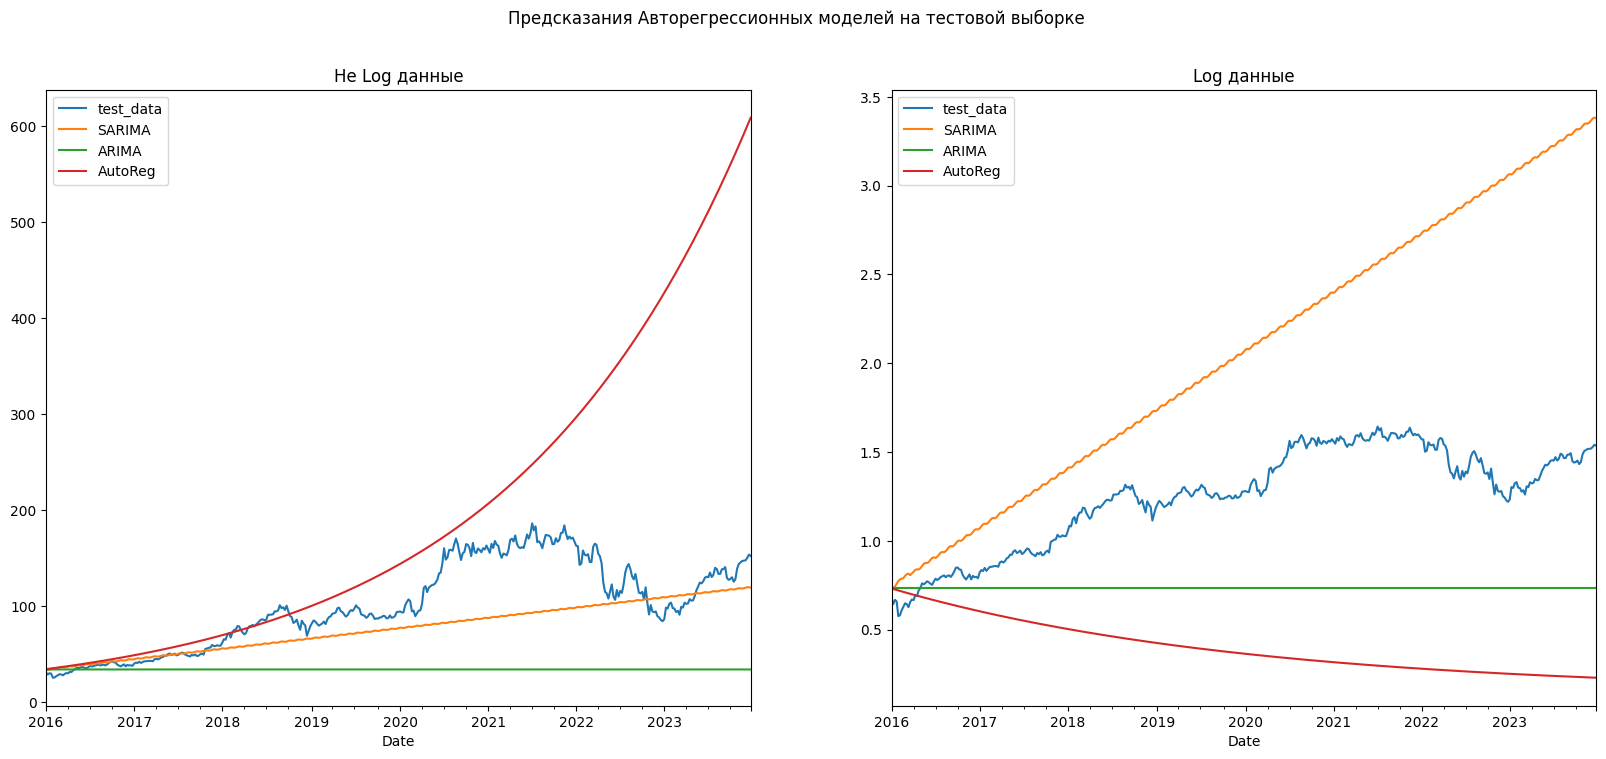

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))

# dfFromDraw.loc[0]['pred_test'].plot(ax=ax)
    
fig.suptitle('Предсказания Авторегрессионных моделей на тестовой выборке')
DrawPredict(test_data=test_data, results=results, IsLogData=False, ax=axs[0], algs=[-1,-2,-3])
DrawPredict(test_data=test_data_log, results=results, IsLogData=True, ax=axs[1], algs=[-1,-2,-3])
# DrawARIMAS(IsLogData=True, ax=axs[1])

    По графику видно, что Авторегрессионные модели не справились с предсказанием на данных в LOG масштабе.
    На на исходных же данных лучше всего себя показала SARIMA

## ML библиотеки

### PROPHET

d:\Diplom\research\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
23:02:19 - cmdstanpy - INFO - Chain [1] start processing
23:02:20 - cmdstanpy - INFO - Chain [1] done processing


Данные в LOG масштабе: False
* {model_name}, Test data, MAPE=0.537


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-04,24.601584,22.791737,26.725547,24.601584,24.601584,0.124124,0.124124,0.124124,0.124124,0.124124,0.124124,0.0,0.0,0.0,24.725708
1,2016-01-11,24.674970,22.751136,26.521778,24.674970,24.674970,-0.053099,-0.053099,-0.053099,-0.053099,-0.053099,-0.053099,0.0,0.0,0.0,24.621871
2,2016-01-18,24.748356,22.523540,26.661154,24.748356,24.748356,-0.150684,-0.150684,-0.150684,-0.150684,-0.150684,-0.150684,0.0,0.0,0.0,24.597673
3,2016-01-25,24.821743,22.761606,26.585875,24.821743,24.821743,-0.152743,-0.152743,-0.152743,-0.152743,-0.152743,-0.152743,0.0,0.0,0.0,24.668999
4,2016-02-01,24.895129,22.866714,26.742802,24.895129,24.895129,-0.121691,-0.121691,-0.121691,-0.121691,-0.121691,-0.121691,0.0,0.0,0.0,24.773438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,2023-11-27,54.836710,48.490287,61.717364,47.913638,60.816283,0.534549,0.534549,0.534549,0.534549,0.534549,0.534549,0.0,0.0,0.0,55.371259
413,2023-12-04,54.910097,48.403290,61.944533,47.948500,60.910926,0.541273,0.541273,0.541273,0.541273,0.541273,0.541273,0.0,0.0,0.0,55.451370
414,2023-12-11,54.983483,48.560066,61.733076,47.983363,61.004031,0.520020,0.520020,0.520020,0.520020,0.520020,0.520020,0.0,0.0,0.0,55.503503
415,2023-12-18,55.056869,48.397867,62.036223,48.018226,61.096922,0.470684,0.470684,0.470684,0.470684,0.470684,0.470684,0.0,0.0,0.0,55.527553


23:02:20 - cmdstanpy - INFO - Chain [1] start processing
23:02:20 - cmdstanpy - INFO - Chain [1] done processing


Данные в LOG масштабе: True
* {model_name}, Test data, MAPE=0.165


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-04,0.584858,0.455502,0.744203,0.584858,0.584858,0.012281,0.012281,0.012281,0.012281,0.012281,0.012281,0.0,0.0,0.0,0.597139
1,2016-01-11,0.587207,0.461398,0.743937,0.587207,0.587207,0.010462,0.010462,0.010462,0.010462,0.010462,0.010462,0.0,0.0,0.0,0.597669
2,2016-01-18,0.589556,0.452096,0.732495,0.589556,0.589556,0.003981,0.003981,0.003981,0.003981,0.003981,0.003981,0.0,0.0,0.0,0.593537
3,2016-01-25,0.591905,0.444394,0.722124,0.591905,0.591905,-0.004817,-0.004817,-0.004817,-0.004817,-0.004817,-0.004817,0.0,0.0,0.0,0.587088
4,2016-02-01,0.594254,0.443638,0.723746,0.594254,0.594254,-0.012804,-0.012804,-0.012804,-0.012804,-0.012804,-0.012804,0.0,0.0,0.0,0.581450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,2023-11-27,1.552618,-1.627076,5.141276,-1.618232,5.117965,0.030626,0.030626,0.030626,0.030626,0.030626,0.030626,0.0,0.0,0.0,1.583244
413,2023-12-04,1.554967,-1.658895,5.190284,-1.623143,5.139691,0.035078,0.035078,0.035078,0.035078,0.035078,0.035078,0.0,0.0,0.0,1.590045
414,2023-12-11,1.557316,-1.667262,5.145156,-1.628054,5.157144,0.029134,0.029134,0.029134,0.029134,0.029134,0.029134,0.0,0.0,0.0,1.586449
415,2023-12-18,1.559664,-1.662757,5.153143,-1.632965,5.173118,0.019084,0.019084,0.019084,0.019084,0.019084,0.019084,0.0,0.0,0.0,1.578749


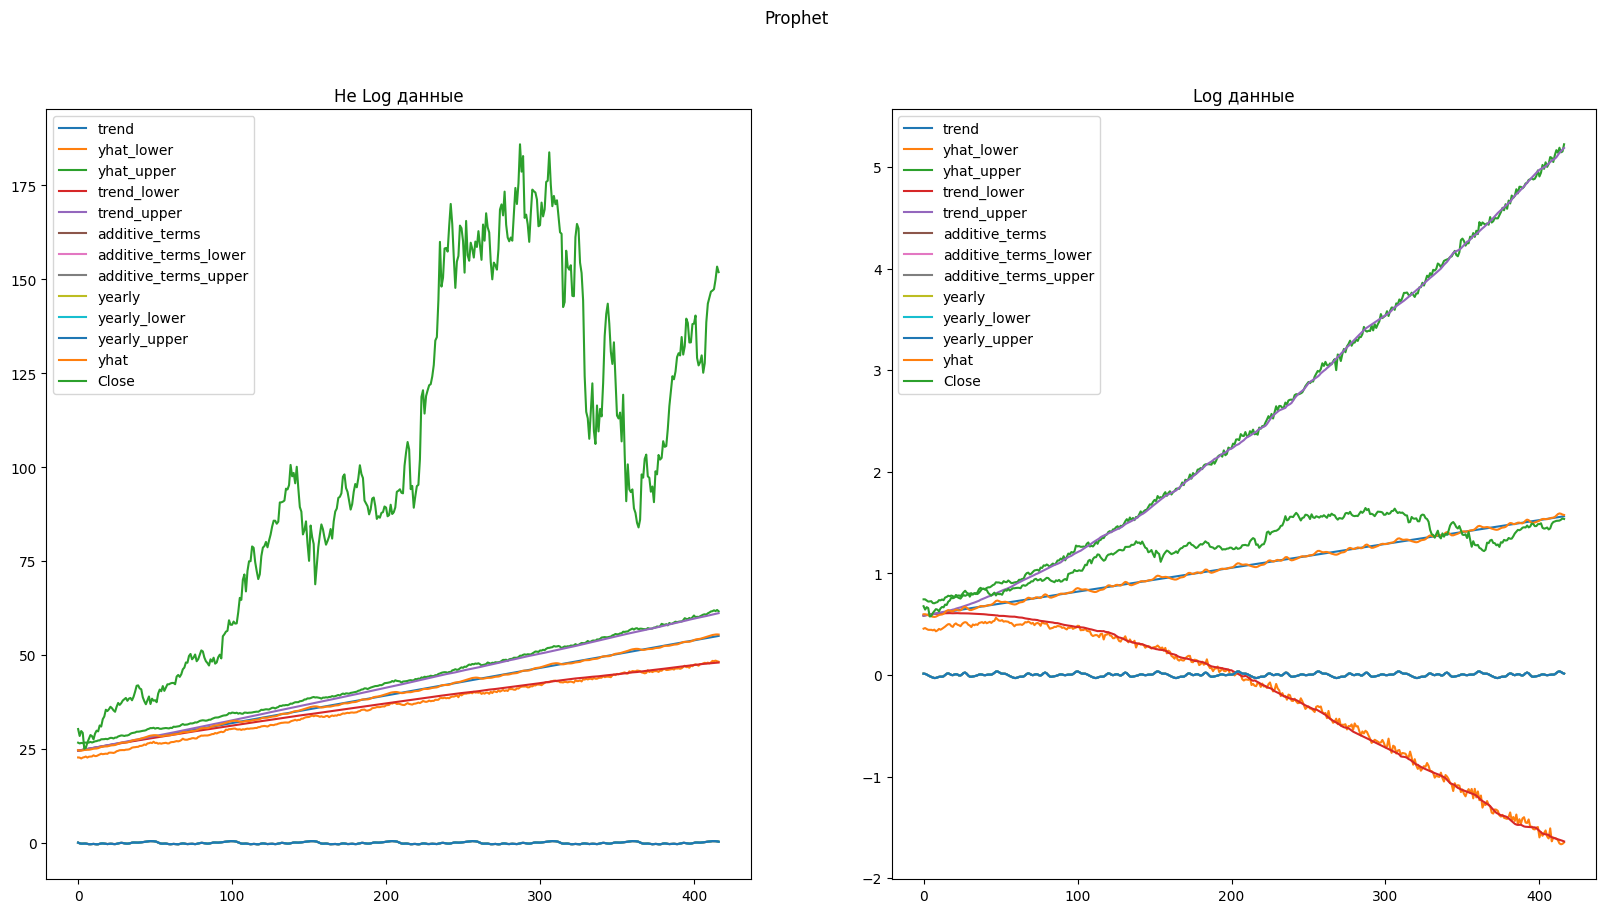

In [65]:
import prophet

def GetMAPEProphet(train_data, test_data, IsLogData, model_name, ax):
    # Подготавливаю данные для Prophet
    train_data_prophet = pd.DataFrame(train_data)
    train_data_prophet = train_data_prophet.reset_index()
    train_data_prophet.columns = ["ds", "y"]
    # train_data_prophet
    test_data_prophet = pd.DataFrame(test_data)
    test_data_prophet = test_data_prophet.reset_index()
    test_data_prophet = test_data_prophet[['Date']]
    test_data_prophet.columns = ['ds']
    # test_data_prophet

    model_proph = prophet.Prophet()
    model_proph.fit(train_data_prophet)

    pred_model_proph = model_proph.predict(test_data_prophet)
    print(f'Данные в LOG масштабе: {IsLogData}')
    print('* {model_name}, Test data, MAPE=%.3f' % MAPE(test_data, pred_model_proph['trend']))

    display(pred_model_proph)
    pred_model_proph[['trend','yhat_lower','yhat_upper','trend_lower','trend_upper','additive_terms','additive_terms_lower','additive_terms_upper','yearly','yearly_lower','yearly_upper', 'yhat']].plot(ax=ax)
    test_data.reset_index()[['Close']].plot(ax=ax)
    ax.set_title('Log данные' if IsLogData else 'Не Log данные')


    return [model_name, IsLogData, model_proph, 999, MAPE(test_data, pred_model_proph['trend']), pred_model_proph['trend']]

modelName = 'Prophet'
fig, axs = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle(modelName)
results.append(Result(*GetMAPEProphet(train_data, test_data, False, modelName, axs[0])))
results.append(Result(*GetMAPEProphet(train_data_log, test_data_log, True, modelName, axs[1])))

    На графике выше видно, что модель Prophet очень точно предсказала линию тренда на LOG данных

In [66]:
# # !pip install fbprophet
# import fbprophet

In [67]:
# m = Prophet()
# m.fit(train_df)
# future = m.make_future_dataframe(periods=predictions)
# forecast = m.predict(future)
# m.plot(forecast)

In [68]:
# m.plot_components(forecast)

In [69]:
### NEURALPROPHET

In [70]:
# !pip3 install git+https://github.com/ourownstory/neural_prophet.git#egg=neuralprophet

In [71]:
# from neuralprophet import NeuralProphet

# model_neralprophet = NeuralProphet()
# model_neralprophet.fit(train_data_prophet) #, freq='W'
# pred_model_neralprophet = model_neralprophet.predict(test_data_prophet)
# print('Proph, Test data, MAPE=%.3f' % MAPE(test_data, pred_model_proph['trend']))
# pred_model_neralprophet

### МОДЕЛИ КЛАССИЧЕСКОГО ML

Данные в LOG масштабе: False
* MLRegressor, Train data, MAPE=0.061
* MLRegressor, Test data, MAPE=0.032
Данные в LOG масштабе: True
* MLRegressor, Train data, MAPE=0.187
* MLRegressor, Test data, MAPE=0.014


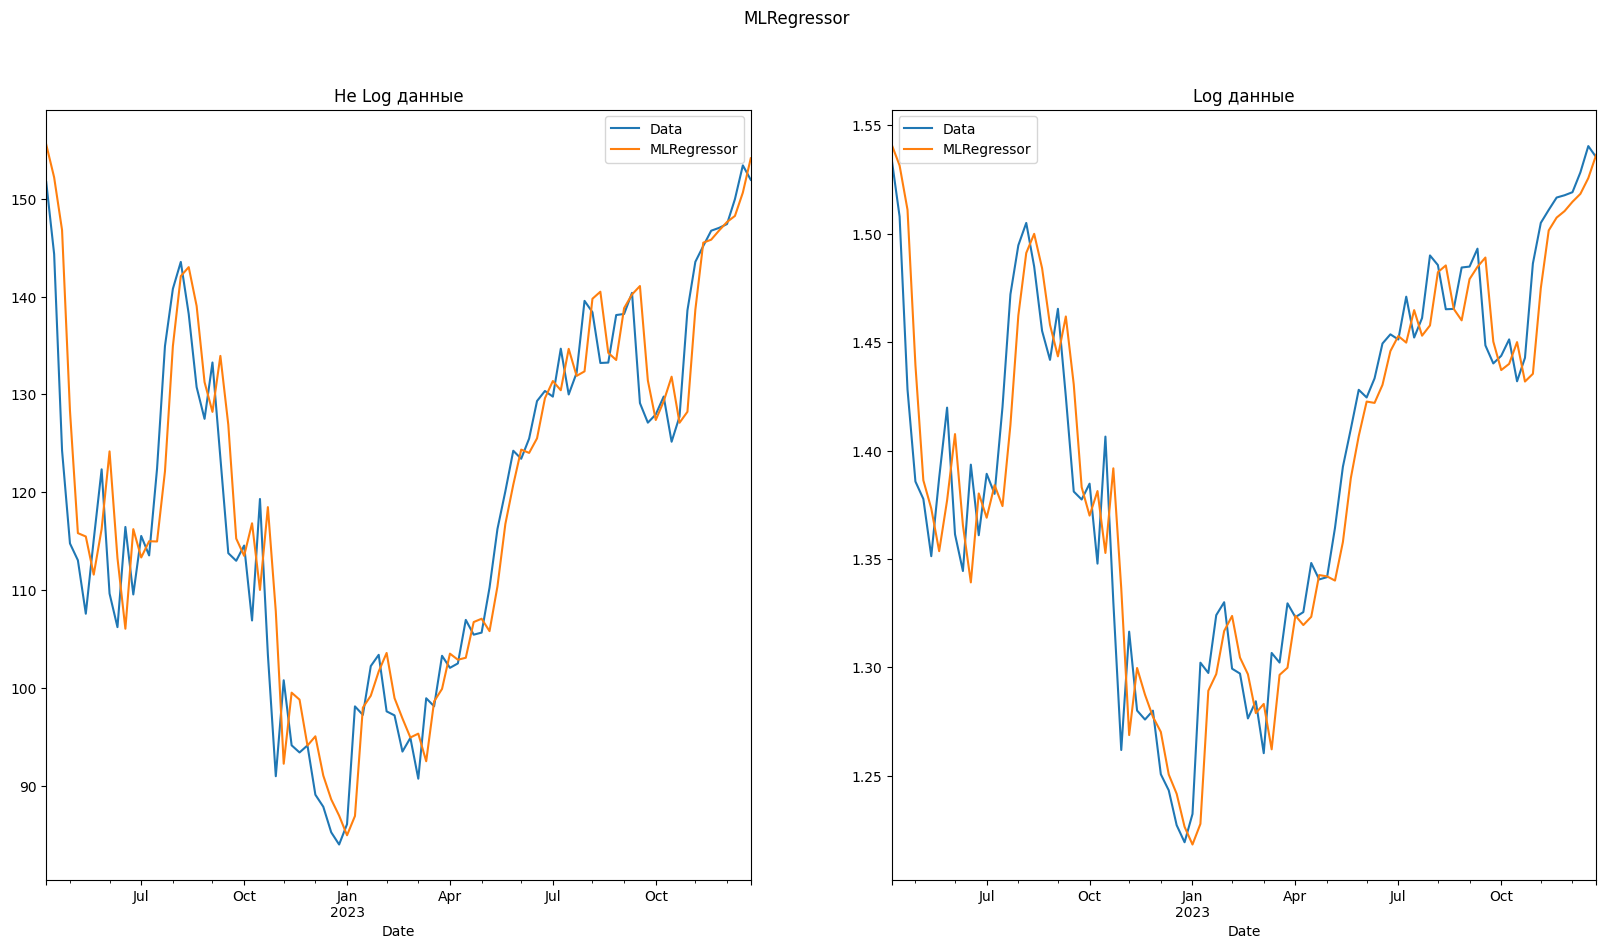

In [72]:
from sklearn.neural_network import MLPRegressor

def GetMAPEMLRegressor(X_train, X_test, y_train, y_test, IsLogData, model_name, ax, draw_all_test=False):
    model_mlregressor = MLPRegressor(
        random_state=0,
        activation='identity',
        solver='adam',
        # learning_rate='adaptive',
        # alpha=1e-1,
        tol=1e-7,
        max_iter=200000,
        hidden_layer_sizes=(400, 300, 200)
    )
    model_mlregressor.fit(X_train, y_train)
    pred_mlregressor_train = model_mlregressor.predict(X_train)
    pred_mlregressor_test = model_mlregressor.predict(X_test)

    print(f'Данные в LOG масштабе: {IsLogData}')
    print(f'* {model_name}, Train data, MAPE=%.3f' % MAPE(y_train, pred_mlregressor_train))
    print(f'* {model_name}, Test data, MAPE=%.3f' % MAPE(y_test, pred_mlregressor_test))
    
    # Рисую предсказание
    pred_mlregressor_test = pd.Series(data=pred_mlregressor_test,
                                    index=y_test.index)
    # fig, ax = plt.subplots(1,1, figsize=(20,5))
    if not draw_all_test:
        y_test.iloc[-90:].plot(ax=ax)
        pred_mlregressor_test.iloc[-90:].plot(ax=ax)
    else:
        y_test.iloc.plot(ax=ax)
        pred_mlregressor_test.iloc.plot(ax=ax)
    # pred_linear_test.iloc[-90:].plot(ax=ax)
    # sns.lineplot(pred_mlregressor_test)
    ax.legend(['Data', 'MLRegressor', 'Linear']);
    ax.set_title('Log данные' if IsLogData else 'Не Log данные')


    return [model_name, IsLogData, model_mlregressor, MAPE(y_train, pred_mlregressor_train), MAPE(y_test, pred_mlregressor_test), pred_mlregressor_test]



modelName = 'MLRegressor'
fig, axs = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle(modelName)
results.append(Result(*GetMAPEMLRegressor(*data, False, modelName, axs[0], draw_all_test=False)))
results.append(Result(*GetMAPEMLRegressor(*data_log, True, modelName, axs[1], draw_all_test=False)))

Добавляю объемы торгов


In [73]:
# train_data = data_crop_log_Scalled.iloc[:crop_index]
# test_data = data_crop_log_Scalled.iloc[crop_index:]

In [74]:
# window = 10
# # Формирую tran DataSet
# trainWithWindowAndTarget = pd.DataFrame()
# for i in range(0, window):
#     trainWithWindowAndTarget[f'Close{i}']=train_data['Close'].shift(-i)
#     trainWithWindowAndTarget[f'Volume{i}']=train_data['Volume'].shift(-i)

# target_temp = train_data[window:]['Close']
# target_temp.index = train_data[:-window].index
# trainWithWindowAndTarget['Target'] = target_temp

# trainWithWindowAndTarget.dropna(axis=0, inplace=True)
# display(trainWithWindowAndTarget)
# # Формирую Тренировочные данные
# X_train = trainWithWindowAndTarget.drop(labels=['Target'], axis=1)
# y_train = trainWithWindowAndTarget['Target']

# # Формирую test DataSet
# testWithWindowAndTarget = pd.DataFrame()
# for i in range(0, window):
#     testWithWindowAndTarget[f'Close{i}']=test_data['Close'].shift(-i)
#     testWithWindowAndTarget[f'Volume{i}']=test_data['Volume'].shift(-i)

# target_temp = test_data[window:]['Close']
# target_temp.index = test_data[:-window].index
# testWithWindowAndTarget['Target'] = target_temp

# testWithWindowAndTarget.dropna(axis=0, inplace=True)
# display(testWithWindowAndTarget)
# # Формирую Тренировочные данные
# X_test = testWithWindowAndTarget.drop(labels=['Target'], axis=1)
# y_test = testWithWindowAndTarget['Target']

In [75]:
# from sklearn.neural_network import MLPRegressor

# model_mlregressor = MLPRegressor(
#     random_state=0,
#     activation='identity',
#     solver='adam',
#     # alpha=1e-1,
#     tol=1e-7,
#     max_iter=200000,
#     hidden_layer_sizes=(400, 300, 200)
# )
# model_mlregressor.fit(X_train, y_train)
# pred_mlregressor_train = model_mlregressor.predict(X_train)
# pred_mlregressor_test = model_mlregressor.predict(X_test)

# print('MLRegressor regression, Train data, MAPE=%.3f' % MAPE(y_train, pred_mlregressor_train))
# print('MLRegressor regression, Test data, MAPE=%.3f' % MAPE(y_test, pred_mlregressor_test))

# # Рисую предсказание для последних 100 дней тестовых данных
# pred_mlregressor_test = pd.Series(data=pred_mlregressor_test,
#                                 index=y_test.index)
# fig, ax = plt.subplots(1,1, figsize=(20,5))
# y_test.iloc[-90:].plot(ax=ax)
# pred_mlregressor_test.iloc[-90:].plot(ax=ax)
# pred_linear_test.iloc[-90:].plot(ax=ax)
# # sns.lineplot(pred_mlregressor_test)
# plt.legend(['Data', 'MLRegressor', 'Linear']);

# Сравнение результатов предсказаний моделей

Сравню все модели, используя талицу. И выберу 2 модели, одна регрессионная (для предсказаний на следущую неделю) и одна для долгосрочных предсказаний

In [76]:
pd.DataFrame(results).sort_values(by='MAPE_Test')

,model_name,IsLogData,model,MAPE_Train,MAPE_Test,pred_test
29,MLRegressor,True,"MLPRegressor(activation='identity', hidden_lay...",0.186514,0.013515,Date 2016-03-14 0.639485 2016-03-21 0.62...
1,LinearRegression,True,LinearRegression(),0.205038,0.014179,Date 2016-03-14 0.632811 2016-03-21 0.62...
3,Ridge,True,Ridge(alpha=0.5),0.203592,0.014812,Date 2016-03-14 0.634219 2016-03-21 0.62...
9,Polynomial_2_Ridge,True,Ridge(),0.228091,0.020387,Date 2016-03-14 0.648537 2016-03-21 0.63...
4,Lasso,False,Lasso(alpha=0.1),0.057509,0.030648,Date 2016-03-14 28.629511 2016-03-21 2...
28,MLRegressor,False,"MLPRegressor(activation='identity', hidden_lay...",0.060731,0.031556,Date 2016-03-14 28.714495 2016-03-21 2...
2,Ridge,False,Ridge(alpha=0.5),0.059593,0.031659,Date 2016-03-14 28.785202 2016-03-21 2...
0,LinearRegression,False,LinearRegression(),0.059592,0.031666,Date 2016-03-14 28.785301 2016-03-21 2...
11,Polynomial_3_Ridge,True,Ridge(),0.243301,0.037132,Date 2016-03-14 0.647224 2016-03-21 0.65...
6,ElasticNet,False,ElasticNet(random_state=0),0.081326,0.038225,Date 2016-03-14 28.334606 2016-03-21 2...


Для краткосрочных предсказаний беру LinearRegression, а для долгосрочных Prophet.

Эти модели требуют разлиыную обработку входных данных, но использовать pipline я не могу т.к. обрабатываю в том числе и целевой признак.

# Ансамблевые модели

## Стекинг

Возьму 3 лучших регрессионных моделей

Данные в LOG масштабе: False
* StackingRegressor, Train data, MAPE=0.064
* StackingRegressor, Test data, MAPE=0.033
Данные в LOG масштабе: True
* StackingRegressor, Train data, MAPE=0.196
* StackingRegressor, Test data, MAPE=0.013


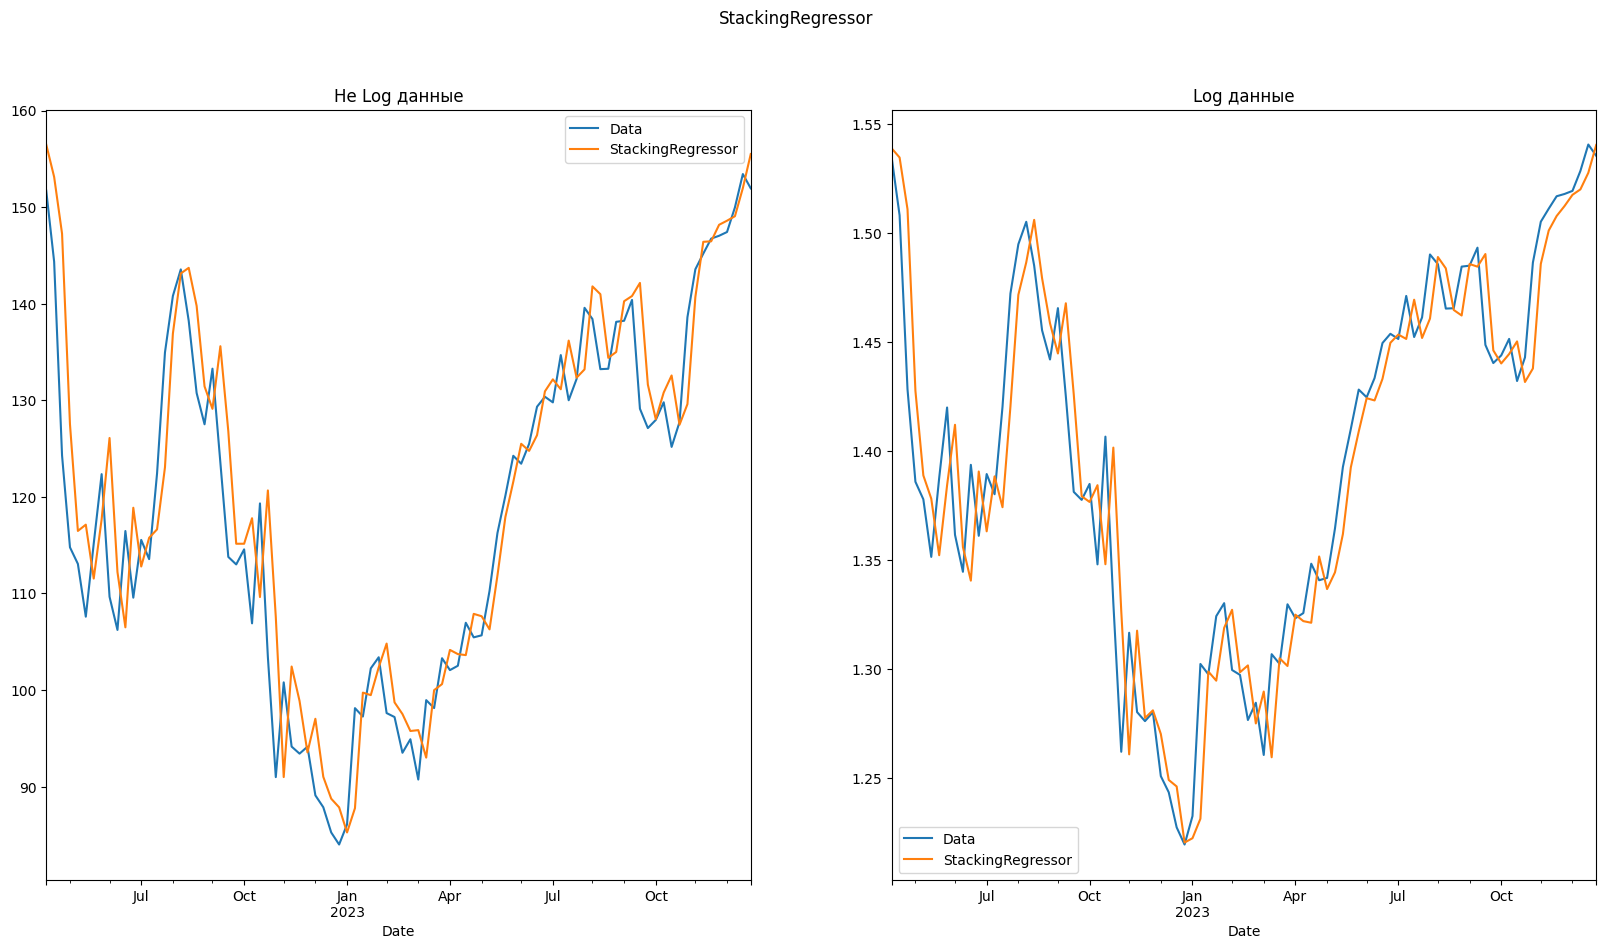

In [77]:
from sklearn.ensemble import StackingRegressor

def GetMAPEStacking(X_train, X_test, y_train, y_test, IsLogData, model_name, ax, draw_all_test=False):
    estimators = [
        ('ml', MLPRegressor(random_state=0,
                            activation='identity',
                            solver='adam',
                            # learning_rate='adaptive',
                            # alpha=1e-1,
                            tol=1e-7,
                            max_iter=200000,
                            hidden_layer_sizes=(400, 300, 200)
        )),
        ('Ridge', Ridge(alpha=0.5)),
        ('Linear', LinearRegression())
    ]
    final_estimator = LinearRegression()
    clf = StackingRegressor(estimators=estimators, 
                            final_estimator=final_estimator
    )
    clf.fit(X_train, y_train)
    pred_clf_train = clf.predict(X_train)
    pred_clf_test = clf.predict(X_test)

    print(f'Данные в LOG масштабе: {IsLogData}')
    print(f'* {model_name}, Train data, MAPE=%.3f' % MAPE(y_train, pred_clf_train))
    print(f'* {model_name}, Test data, MAPE=%.3f' % MAPE(y_test, pred_clf_test))

    # Рисую предсказание
    pred_clf_test = pd.Series(data=pred_clf_test,
                                    index=y_test.index)
    # fig, ax = plt.subplots(1,1, figsize=(20,5))
    if not draw_all_test:
        y_test.iloc[-90:].plot(ax=ax)
        pred_clf_test.iloc[-90:].plot(ax=ax)
    else:
        y_test.iloc.plot(ax=ax)
        pred_clf_test.iloc.plot(ax=ax)

    ax.legend(['Data', 'StackingRegressor']);
    ax.set_title('Log данные' if IsLogData else 'Не Log данные')


    return [model_name, IsLogData, clf, MAPE(y_train, pred_clf_train), MAPE(y_test, pred_clf_test), pred_clf_test]



modelName = 'StackingRegressor'
fig, axs = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle(modelName)
results.append(Result(*GetMAPEStacking(*data, False, modelName, axs[0], draw_all_test=False)))
results.append(Result(*GetMAPEStacking(*data_log, True, modelName, axs[1], draw_all_test=False)))

## Голосование

Данные в LOG масштабе: False
* VotingRegressor, Train data, MAPE=0.060
* VotingRegressor, Test data, MAPE=0.032
Данные в LOG масштабе: True
* VotingRegressor, Train data, MAPE=0.198
* VotingRegressor, Test data, MAPE=0.014


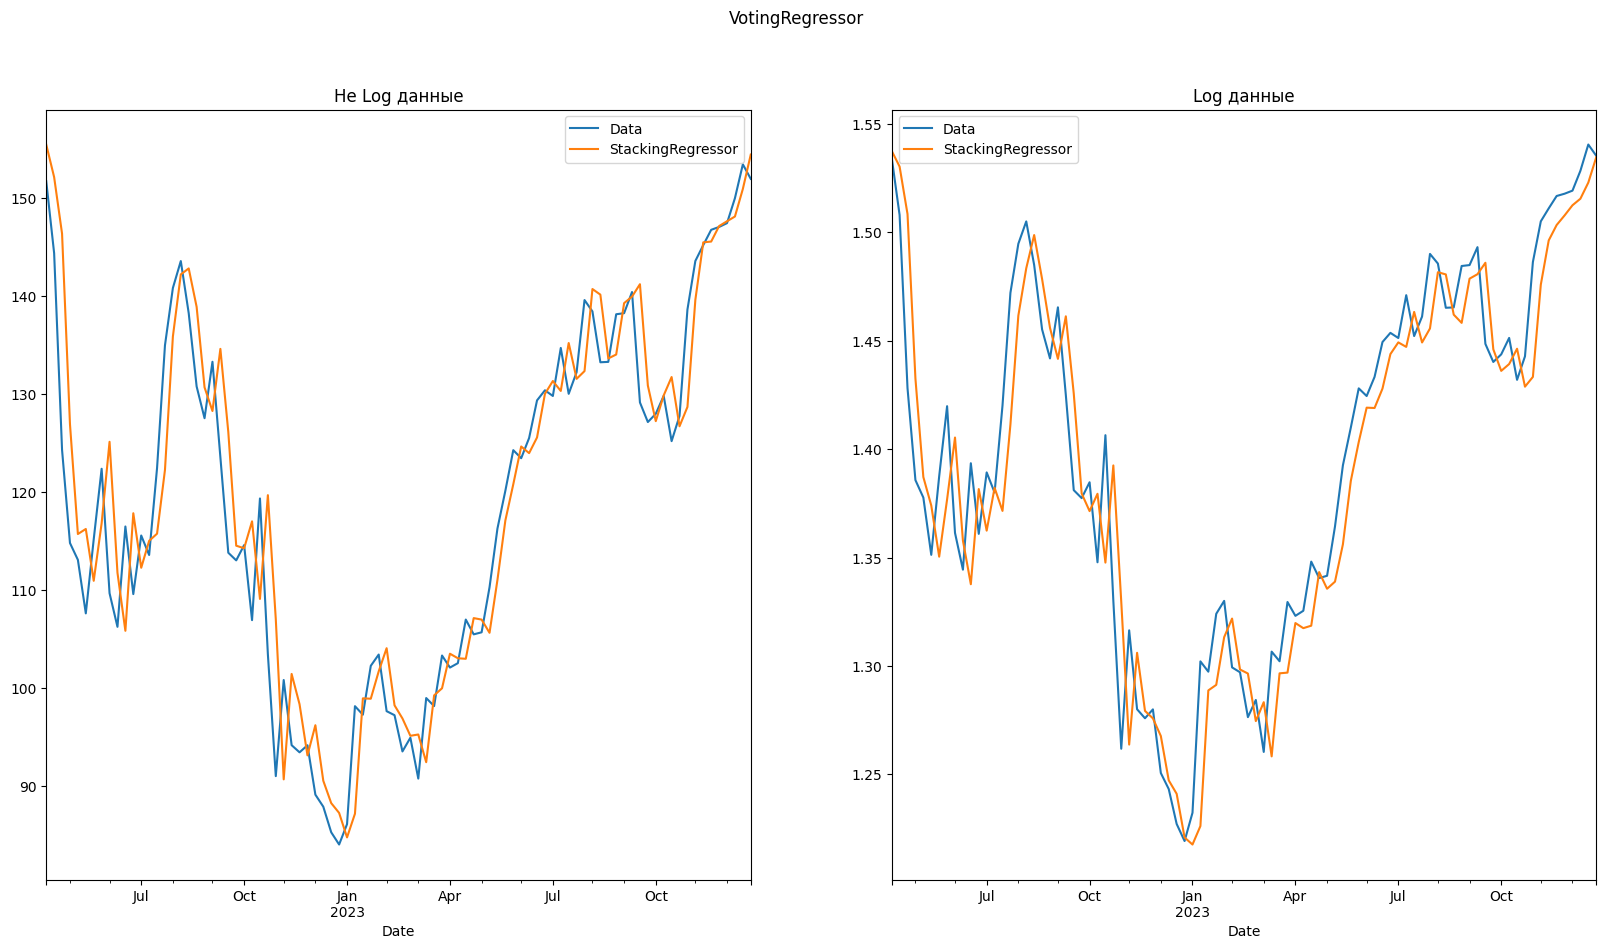

In [78]:
from sklearn.ensemble import VotingRegressor

def GetMAPEVoting(X_train, X_test, y_train, y_test, IsLogData, model_name, ax, draw_all_test=False):
    estimators = [
        ('ml', MLPRegressor(random_state=0,
                            activation='identity',
                            solver='adam',
                            # learning_rate='adaptive',
                            # alpha=1e-1,
                            tol=1e-7,
                            max_iter=200000,
                            hidden_layer_sizes=(400, 300, 200)
    )),
        ('Ridge', Ridge(alpha=0.5)),
        ('Linear', LinearRegression())
    ]
    final_estimator = LinearRegression()
    clf = VotingRegressor(estimators=estimators)
    clf.fit(X_train, y_train)
    pred_clf_train = clf.predict(X_train)
    pred_clf_test = clf.predict(X_test)

    print(f'Данные в LOG масштабе: {IsLogData}')
    print(f'* {model_name}, Train data, MAPE=%.3f' % MAPE(y_train, pred_clf_train))
    print(f'* {model_name}, Test data, MAPE=%.3f' % MAPE(y_test, pred_clf_test))

    # Рисую предсказание
    pred_clf_test = pd.Series(data=pred_clf_test,
                                    index=y_test.index)
    # fig, ax = plt.subplots(1,1, figsize=(20,5))
    if not draw_all_test:
        y_test.iloc[-90:].plot(ax=ax)
        pred_clf_test.iloc[-90:].plot(ax=ax)
    else:
        y_test.iloc.plot(ax=ax)
        pred_clf_test.iloc.plot(ax=ax)

    ax.legend(['Data', 'StackingRegressor']);
    ax.set_title('Log данные' if IsLogData else 'Не Log данные')


    return [model_name, IsLogData, clf, MAPE(y_train, pred_clf_train), MAPE(y_test, pred_clf_test), pred_clf_test]



modelName = 'VotingRegressor'
fig, axs = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle(modelName)
results.append(Result(*GetMAPEVoting(*data, False, modelName, axs[0], draw_all_test=False)))
results.append(Result(*GetMAPEVoting(*data_log, True, modelName, axs[1], draw_all_test=False)))

# Бустинг

## ADABoosting

Данные в LOG масштабе: False
* ADABoosting, Train data, MAPE=0.070
* ADABoosting, Test data, MAPE=0.036
Данные в LOG масштабе: True
* ADABoosting, Train data, MAPE=0.216
* ADABoosting, Test data, MAPE=0.016


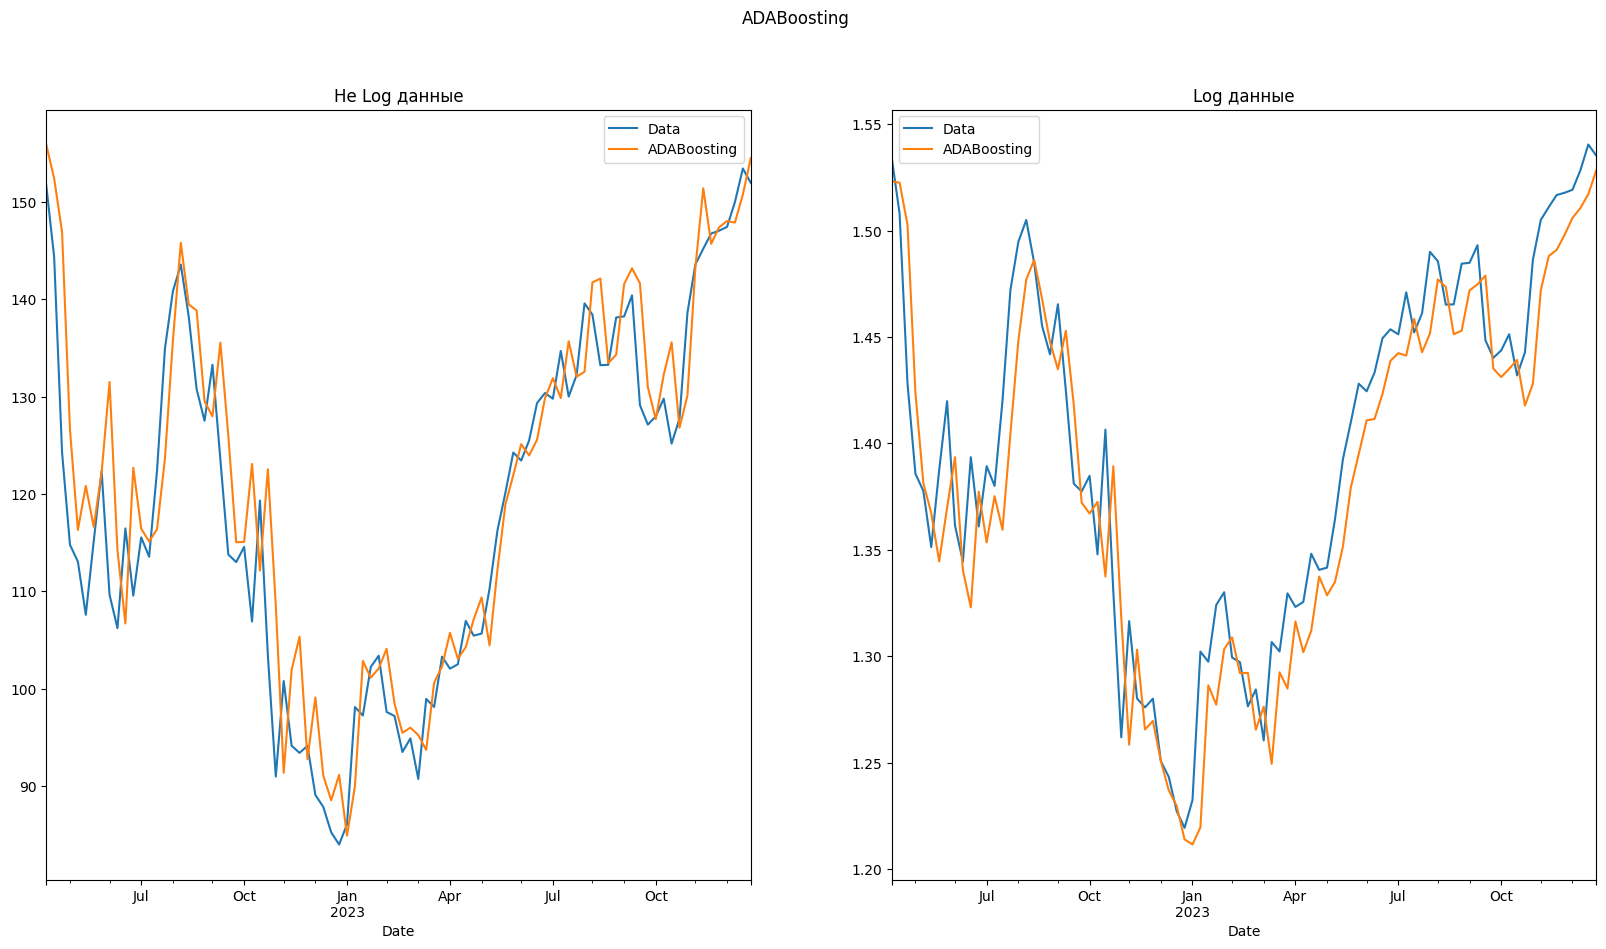

In [79]:
from sklearn.ensemble import AdaBoostRegressor


def GetMAPEADABoosting(X_train, X_test, y_train, y_test, IsLogData, model_name, ax, draw_all_test=False):
    estimators = [
        ('ml', MLPRegressor(random_state=0,
                            activation='identity',
                            solver='adam',
                            # learning_rate='adaptive',
                            # alpha=1e-1,
                            tol=1e-7,
                            max_iter=200000,
                            hidden_layer_sizes=(400, 300, 200)
        )),
        ('Ridge', Ridge(alpha=0.5)),
        ('Linear', LinearRegression())
    ]
    final_estimator = LinearRegression()
    base_estimator = StackingRegressor(estimators=estimators, 
                                        final_estimator=final_estimator
    )
    clf = AdaBoostRegressor(estimator=base_estimator, n_estimators=4, random_state=0)
    # clf = AdaBoostRegressor(estimator=MLPRegressor(), n_estimators=4000, random_state=0)
    clf.fit(X_train, y_train)
    pred_clf_train = clf.predict(X_train)
    pred_clf_test = clf.predict(X_test)

    print(f'Данные в LOG масштабе: {IsLogData}')
    print(f'* {model_name}, Train data, MAPE=%.3f' % MAPE(y_train, pred_clf_train))
    print(f'* {model_name}, Test data, MAPE=%.3f' % MAPE(y_test, pred_clf_test))

    # Рисую предсказание
    pred_clf_test = pd.Series(data=pred_clf_test,
                                    index=y_test.index)
    # fig, ax = plt.subplots(1,1, figsize=(20,5))
    if not draw_all_test:
        y_test.iloc[-90:].plot(ax=ax)
        pred_clf_test.iloc[-90:].plot(ax=ax)
    else:
        y_test.iloc.plot(ax=ax)
        pred_clf_test.iloc.plot(ax=ax)

    ax.legend(['Data', 'ADABoosting']);
    ax.set_title('Log данные' if IsLogData else 'Не Log данные')


    return [model_name, IsLogData, clf, MAPE(y_train, pred_clf_train), MAPE(y_test, pred_clf_test), pred_clf_test]

modelName = 'ADABoosting'
fig, axs = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle(modelName)
results.append(Result(*GetMAPEADABoosting(*data, False, modelName, axs[0], draw_all_test=False)))
results.append(Result(*GetMAPEADABoosting(*data_log, True, modelName, axs[1], draw_all_test=False)))

# Подбор гиперпараметров

Сравню результаты всех предыдущих моделей и выберу регрессионную модель для подбора гиперпараметров

In [80]:
display(pd.DataFrame(results).sort_values(by='MAPE_Test'))

,model_name,IsLogData,model,MAPE_Train,MAPE_Test,pred_test
31,StackingRegressor,True,"StackingRegressor(estimators=[('ml',\n ...",0.195707,0.013285,Date 2016-03-14 0.636457 2016-03-21 0.62...
29,MLRegressor,True,"MLPRegressor(activation='identity', hidden_lay...",0.186514,0.013515,Date 2016-03-14 0.639485 2016-03-21 0.62...
33,VotingRegressor,True,"VotingRegressor(estimators=[('ml',\n ...",0.197962,0.014065,Date 2016-03-14 0.635505 2016-03-21 0.62...
1,LinearRegression,True,LinearRegression(),0.205038,0.014179,Date 2016-03-14 0.632811 2016-03-21 0.62...
3,Ridge,True,Ridge(alpha=0.5),0.203592,0.014812,Date 2016-03-14 0.634219 2016-03-21 0.62...
35,ADABoosting,True,"(StackingRegressor(estimators=[('ml',\n ...",0.216173,0.016188,Date 2016-03-14 0.626945 2016-03-21 0.62...
9,Polynomial_2_Ridge,True,Ridge(),0.228091,0.020387,Date 2016-03-14 0.648537 2016-03-21 0.63...
4,Lasso,False,Lasso(alpha=0.1),0.057509,0.030648,Date 2016-03-14 28.629511 2016-03-21 2...
28,MLRegressor,False,"MLPRegressor(activation='identity', hidden_lay...",0.060731,0.031556,Date 2016-03-14 28.714495 2016-03-21 2...
32,VotingRegressor,False,"VotingRegressor(estimators=[('ml',\n ...",0.059797,0.031556,Date 2016-03-14 28.761666 2016-03-21 2...


## Optuna

In [81]:
from datetime import datetime
import optuna

def objective(trial):
    global data
    model_name = 'Optuna'
    X_train, X_test, y_train, y_test = data
    IsLogData = True



    ml_activation = trial.suggest_categorical("ml_activation", ['relu', 'identity', 'logistic', 'tanh'])
    ml_solver = trial.suggest_categorical("ml_solver", ['adam']) # ''sgd'б lbfgs'
    ml_learning_rate = trial.suggest_categorical("ml_learning_rate", ['constant', 'invscaling', 'adaptive'])
    ml_alpha = trial.suggest_float("ml_alpha", 1e-6, 1.0, log=True)
    ml_tol = trial.suggest_float("ml_tol", 1e-6, 1.0, log=True)
    ml_hiden_layers = trial.suggest_int("ml_hiden_layers", 1, 3)
    ml_hiden_n_in_layer1 = trial.suggest_int("ml_hiden_n_in_layer1", 10, 400)
    ml_hiden_n_in_layer2 = trial.suggest_int("ml_hiden_n_in_layer2", 10, 400)
    ml_hiden_n_in_layer3 = trial.suggest_int("ml_hiden_n_in_layer3", 10, 400)

    r_alpha = trial.suggest_float("r_alpha", 1e-6, 1.0, log=True)
    r_solver = trial.suggest_categorical("r_solver", ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']) #'lbfgs'
    # r_max_iter = trial.suggest_int("r_max_iter", 1, 3)

    if ml_hiden_layers == 1:
        ml_hidden_layer_sizes = (ml_hiden_n_in_layer1)
    elif ml_hiden_layers == 2:
        ml_hidden_layer_sizes = (ml_hiden_n_in_layer1, ml_hiden_n_in_layer2)
    elif ml_hiden_layers == 3:
        ml_hidden_layer_sizes = (ml_hiden_n_in_layer1, ml_hiden_n_in_layer2, ml_hiden_n_in_layer3)

    estimators = [
        ('ml', MLPRegressor(random_state=0,
                            activation=ml_activation,
                            solver=ml_solver,
                            learning_rate=ml_learning_rate,
                            alpha=ml_alpha,
                            tol=ml_tol,
                            max_iter=5000,
                            hidden_layer_sizes=ml_hidden_layer_sizes
        )),
        ('Ridge', Ridge(alpha=r_alpha,
                        solver=r_solver,
                        max_iter=500,
                        random_state=0)),
        ('Linear', LinearRegression())
    ]
    final_estimator = LinearRegression()
    clf = StackingRegressor(estimators=estimators, 
                            final_estimator=final_estimator
    )
    clf.fit(X_train, y_train)
    pred_clf_train = clf.predict(X_train)
    pred_clf_test = clf.predict(X_test)

    # print(f'Данные в LOG масштабе: {IsLogData}')
    # print(f'* {model_name}, Train data, MAPE=%.3f' % MAPE(y_train, pred_clf_train))
    # print(f'* {model_name}, Test data, MAPE=%.3f' % MAPE(y_test, pred_clf_test))



    return MAPE(y_test, pred_clf_test)


study_name = f"StackingRegressor {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}" 
direction = 'minimize'
study = optuna.create_study(direction=direction,
                            storage='sqlite:///optuna/db/optuna.db',
                            study_name=study_name)
study.optimize(objective,
               n_trials=5,
               n_jobs=1,
               show_progress_bar=True)

study.best_params 

[I 2024-02-06 23:07:07,685] A new study created in RDB with name: StackingRegressor 2024-02-06 23:07:07
Best trial: 0. Best value: 0.0360004:  20%|██        | 1/5 [00:31<02:06, 31.73s/it]

[I 2024-02-06 23:07:39,412] Trial 0 finished with value: 0.03600044323293637 and parameters: {'ml_activation': 'tanh', 'ml_solver': 'adam', 'ml_learning_rate': 'invscaling', 'ml_alpha': 0.004558451706193714, 'ml_tol': 0.0002885447658704011, 'ml_hiden_layers': 2, 'ml_hiden_n_in_layer1': 337, 'ml_hiden_n_in_layer2': 365, 'ml_hiden_n_in_layer3': 199, 'r_alpha': 0.03296547670843773, 'r_solver': 'lsqr'}. Best is trial 0 with value: 0.03600044323293637.


Best trial: 1. Best value: 0.0348839:  40%|████      | 2/5 [00:34<00:44, 14.95s/it]

[I 2024-02-06 23:07:42,606] Trial 1 finished with value: 0.03488389357755757 and parameters: {'ml_activation': 'tanh', 'ml_solver': 'adam', 'ml_learning_rate': 'constant', 'ml_alpha': 0.2016668486096037, 'ml_tol': 0.10028536539405894, 'ml_hiden_layers': 1, 'ml_hiden_n_in_layer1': 295, 'ml_hiden_n_in_layer2': 267, 'ml_hiden_n_in_layer3': 172, 'r_alpha': 0.020354714134129284, 'r_solver': 'lsqr'}. Best is trial 1 with value: 0.03488389357755757.


Best trial: 1. Best value: 0.0348839:  60%|██████    | 3/5 [01:14<00:51, 25.98s/it]

[I 2024-02-06 23:08:21,710] Trial 2 finished with value: 0.03493395485767168 and parameters: {'ml_activation': 'tanh', 'ml_solver': 'adam', 'ml_learning_rate': 'adaptive', 'ml_alpha': 0.003034590223571351, 'ml_tol': 0.0002678886228722923, 'ml_hiden_layers': 3, 'ml_hiden_n_in_layer1': 55, 'ml_hiden_n_in_layer2': 186, 'ml_hiden_n_in_layer3': 30, 'r_alpha': 3.7953888548499863e-06, 'r_solver': 'auto'}. Best is trial 1 with value: 0.03488389357755757.


d:\Diplom\research\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Diplom\research\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Diplom\research\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Diplom\research\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Diplom\research\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Best trial: 1. Best value: 0.0348839:  80%|████████  | 4/5 [01:55<00:32, 32.24s/it]

[I 2024-02-06 23:09:03,555] Trial 3 finished with value: 0.0351955974066519 and parameters: {'ml_activation': 'tanh', 'ml_solver': 'adam', 'ml_learning_rate': 'constant', 'ml_alpha': 0.00028191771964051365, 'ml_tol': 2.4733598422488876e-06, 'ml_hiden_layers': 3, 'ml_hiden_n_in_layer1': 350, 'ml_hiden_n_in_layer2': 349, 'ml_hiden_n_in_layer3': 174, 'r_alpha': 0.0028848554151976384, 'r_solver': 'saga'}. Best is trial 1 with value: 0.03488389357755757.


Best trial: 1. Best value: 0.0348839: 100%|██████████| 5/5 [02:11<00:00, 26.28s/it]

[I 2024-02-06 23:09:19,088] Trial 4 finished with value: 0.03641260166853299 and parameters: {'ml_activation': 'tanh', 'ml_solver': 'adam', 'ml_learning_rate': 'constant', 'ml_alpha': 1.2104309074650745e-06, 'ml_tol': 9.709654961880023e-05, 'ml_hiden_layers': 1, 'ml_hiden_n_in_layer1': 198, 'ml_hiden_n_in_layer2': 224, 'ml_hiden_n_in_layer3': 280, 'r_alpha': 1.7105929565112685e-05, 'r_solver': 'svd'}. Best is trial 1 with value: 0.03488389357755757.


{'ml_activation': 'tanh',
 'ml_solver': 'adam',
 'ml_learning_rate': 'constant',
 'ml_alpha': 0.2016668486096037,
 'ml_tol': 0.10028536539405894,
 'ml_hiden_layers': 1,
 'ml_hiden_n_in_layer1': 295,
 'ml_hiden_n_in_layer2': 267,
 'ml_hiden_n_in_layer3': 172,
 'r_alpha': 0.020354714134129284,
 'r_solver': 'lsqr'}

# Сохраняю модельи для использования в микросервисах

Сохраняю Scaller

In [82]:
import pickle

with open('models/scalers.md', 'wb') as output:
    pickle.dump(scallers, output)
# scaler_standart.inverse_transform


Сохраняю регрессионная модель для предсказания на один шаг

In [84]:
import pickle

def SaveModel(ml_activation, ml_solver, ml_learning_rate, ml_alpha, ml_tol, ml_hiden_layers, ml_hiden_n_in_layer1, ml_hiden_n_in_layer2, ml_hiden_n_in_layer3, r_alpha, r_solver):
    global data
    X_train, X_test, y_train, y_test = data
    
    if ml_hiden_layers == 1:
        ml_hidden_layer_sizes = (ml_hiden_n_in_layer1)
    elif ml_hiden_layers == 2:
        ml_hidden_layer_sizes = (ml_hiden_n_in_layer1, ml_hiden_n_in_layer2)
    elif ml_hiden_layers == 3:
        ml_hidden_layer_sizes = (ml_hiden_n_in_layer1, ml_hiden_n_in_layer2, ml_hiden_n_in_layer3)


    estimators = [
        ('ml', MLPRegressor(random_state=0,
                            activation=ml_activation,
                            solver=ml_solver,
                            learning_rate=ml_learning_rate,
                            alpha=ml_alpha,
                            tol=ml_tol,
                            max_iter=5000,
                            hidden_layer_sizes=ml_hidden_layer_sizes
        )),
        ('Ridge', Ridge(alpha=r_alpha,
                        solver=r_solver,
                        max_iter=500,
                        random_state=0)),
        ('Linear', LinearRegression())
    ]
    final_estimator = LinearRegression()
    clf = StackingRegressor(estimators=estimators, 
                            final_estimator=final_estimator
    )
    clf.fit(X_train, y_train)


    with open('models/regressModel.md', 'wb') as output:
        pickle.dump(clf, output)

SaveModel(**study.best_params)

Сохраняю модель времянных рядов для долгосрочных прогнозов

In [85]:
import pickle

dfFromSave = pd.DataFrame(results)
mask = (dfFromSave['model_name'] == 'Prophet') & (dfFromSave['IsLogData'] == True)
model = dfFromSave[mask].model.values[0]

with open('models/timeSeriesModel.md', 'wb') as output:
        pickle.dump(model, output)